## Welcome to Plotbot!

👋 Welcome to Plotbot! A tool for downloading and plotting data from the Parker Solar Probe. Created by Dr. Jaye Verniero and Dr. Robert Alexander. Note: this is a work in progress.

First, click in the upper right hand corner of this window to select the plotbot environment. It should be named plotbot_env (Python 3.12.4). Alternatively, you'll be prompted to select the environment when you run the first cell below.







### Plotbot

Let's get started by importing plotbot:

In [1]:
# You may need to install these manually 
# !pip install ipywidgets
# !pip install pytest 
# !pip install termcolor 

In [2]:
import plotbot
from plotbot import *

initialized server_access
initialized global_tracker
initialized ploptions
initialized data_cubby
initialized plot_manager
initialized mag_rtn_4sa class
initialized mag_rtn class
initialized mag_sc_4sa class
initialized mag_sc class
initialized epad class
initialized epad_hr class
initialized proton class
initialized proton_hr class
initialized proton_fits class
initialized ham_class
🔉 initialized audifier

Importing libraries, this may take a moment. Hold tight... 

✅ Imported standard libraries and utilities.
✅ Imported numpy, pandas, and scipy libraries.
✅ Imported matplotlib libraries.
✅ Imported cdflib, BeautifulSoup, requests, dateutil, and datetime libraries.

🤖 Plotbot Initialized
✨ Showdahodo initialized
📈📉 Multiplot Initialized


Feel free to use ✨Run All✨ to 
initialize all the cells, then scroll down to the plotbot section
and start plotting to your heart's content 📈


In [3]:
#----Print manager----///
print_manager.show_status = False  # Status prints, ⭐️ useful for basic status updates
print_manager.show_processing = False # e.g. Processing mag_RTN_4sa...
print_manager.show_custom_debug = False  # Custom variable operations debugging
print_manager.show_debug = False  # Debug prints, helpful for debugging (will print LOTS of lines)
print_manager.show_time_tracking = False  # For tracking datetime array inputs and outputs
print_manager.show_derived = False
print_manager.show_warnings = False     # Turn off warning messages
print_manager.show_variable_testing = False
print_manager.show_test = False  # Turn off test-specific output

print_manager.show_module_prefix = False  # Show/Hide [print_manager]
print_manager.show_category_prefix = False  # Show/Hide [PROCESS], [TIME], etc.

In [ ]:
# Set global font settings (will figure out where this should go / how it should be implemented)
# plt.rcParams.update({
#     'font.family': 'Arial',
#     'font.sans-serif': ['Arial'],
#     'axes.labelweight': 'normal',
#     'font.weight': 'normal',
#     'mathtext.fontset': 'custom',
#     'mathtext.rm': 'Arial',
#     'mathtext.it': 'Arial:italic',
#     'mathtext.bf': 'Arial:bold'
# })

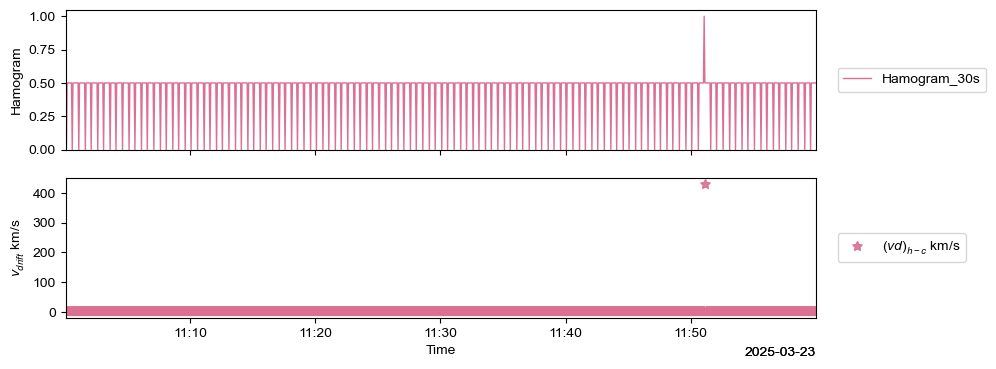

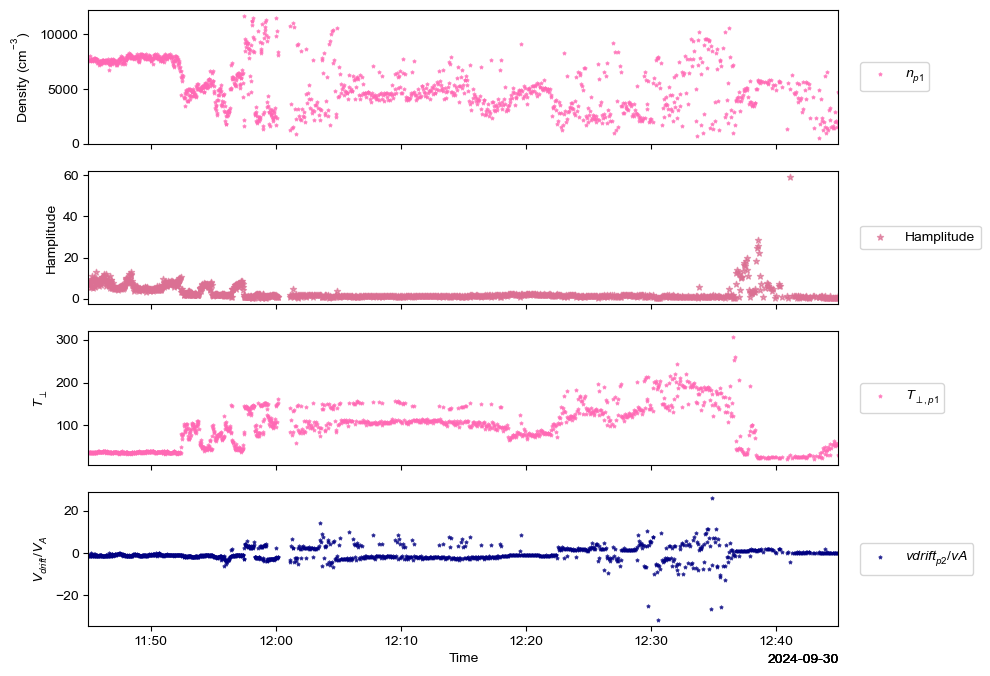

In [4]:
#Example HAM 🍖 and fits plotbot calls!

ham_trange = ['2025-03-23 11:00:00.000', '2025-03-23 12:00:00.000']

#server_access.username = 'your_username_here'

plotbot(ham_trange, ham.hamogram_30s, 1, ham.ham_core_drift, 2)

fits_trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

plotbot(fits_trange, proton_fits.np1, 1, proton_fits.ham_param, 2, proton_fits.Tperp1, 3, proton_fits.vdrift_va_pfits, 4)

--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---


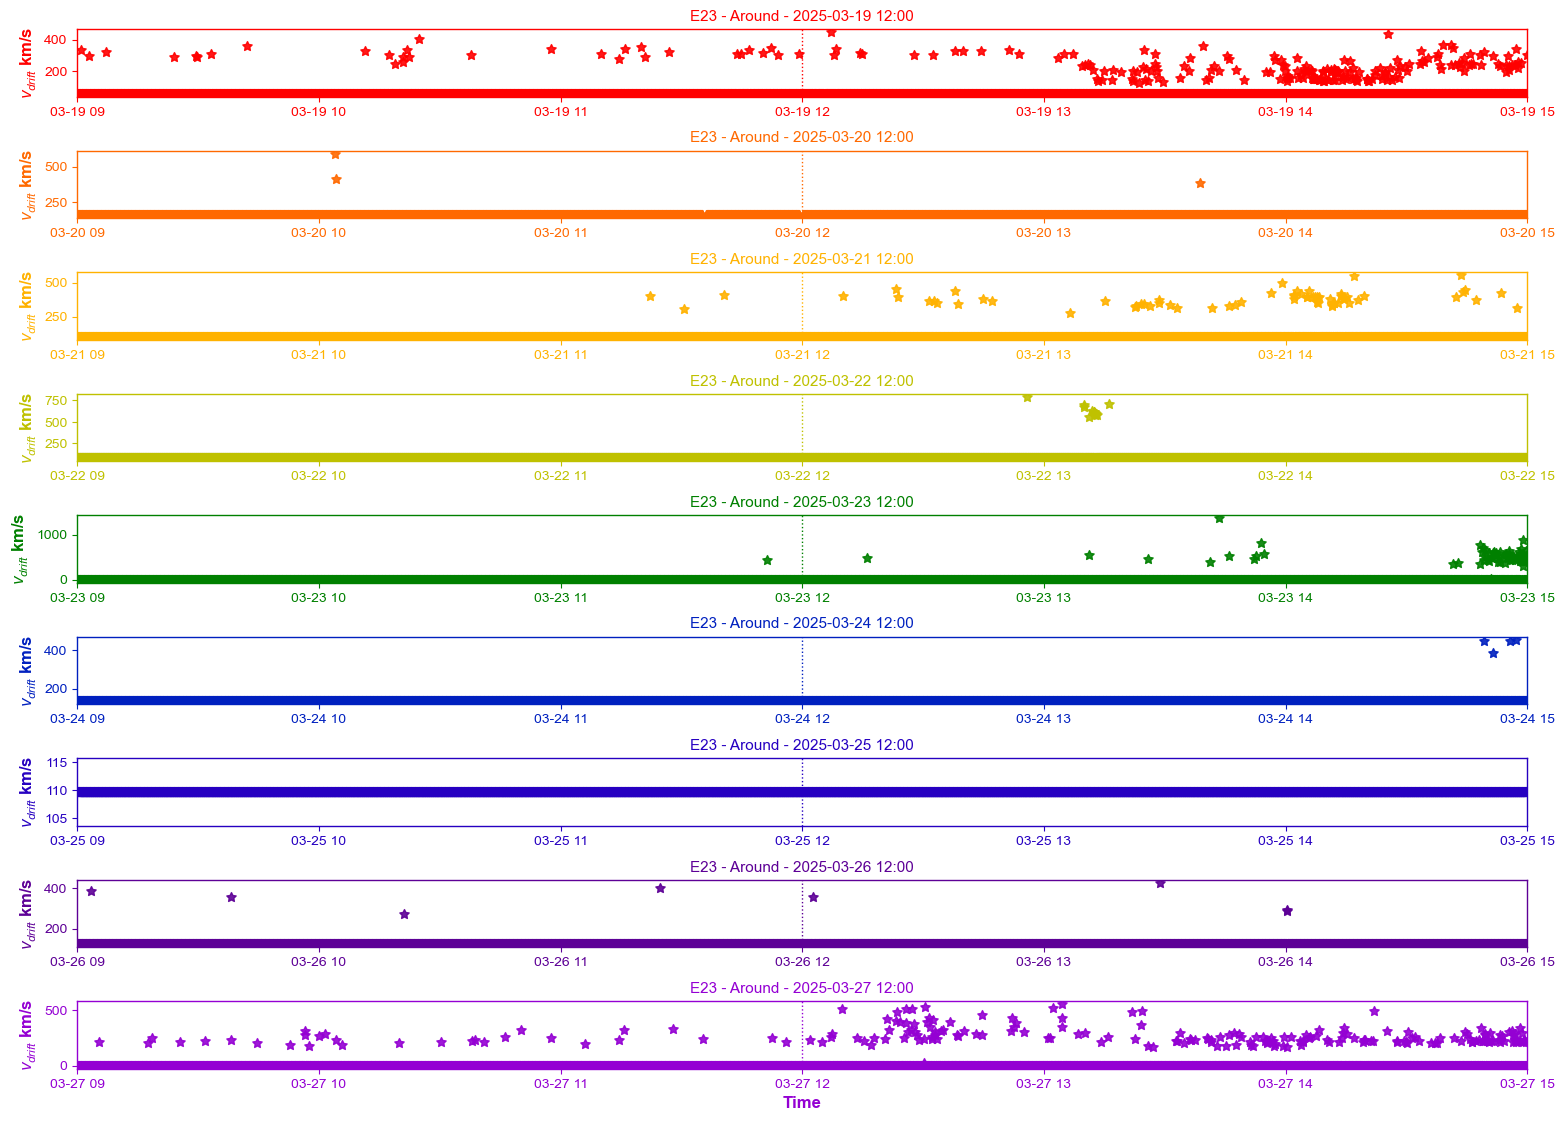

In [5]:
# Example HAM 🍖 Multiplot Call for Ham/Core Drift Speed across Multiple Days around noon (using all the files you provided)

print("--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---")

# Only use the regular drift speed (not normalized)
ham_drift_vars = [
    ham.ham_core_drift  # Just the drift speed in km/s (not normalized by Alfven speed)
]

# Define ham noon times as a list of dictionaries
ham_noon_times = [
    {'time': '2025-03-19 12:00:00.000'},  # March 19th noon
    {'time': '2025-03-20 12:00:00.000'},  # March 20th noon
    {'time': '2025-03-21 12:00:00.000'},  # March 21st noon
    {'time': '2025-03-22 12:00:00.000'},  # March 22nd noon
    {'time': '2025-03-23 12:00:00.000'},  # March 23rd noon
    {'time': '2025-03-24 12:00:00.000'},  # March 24th noon
    {'time': '2025-03-25 12:00:00.000'},  # March 25th noon
    {'time': '2025-03-26 12:00:00.000'},  # March 26th noon
    {'time': '2025-03-27 12:00:00.000'},  # March 27th noon
]

# Create all plot tuples using list comprehension
all_plots = [(day['time'], var) for day in ham_noon_times for var in ham_drift_vars]

# --- Configure Plot Options ---
plt.options.reset() 

# Your existing plot parameters
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 12
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 4

plt.options.use_single_title = False
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

plt.options.window = '6:00:00'  # +/- 3 hours around noon
plt.options.position = 'around'
plt.options.draw_vertical_line = True

plt.options.color_mode = 'rainbow'
plt.options.single_color = None

plt.options.use_relative_time = False
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

# Generate the multiplot showing all days
fig, axs = multiplot(all_plots);

--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---


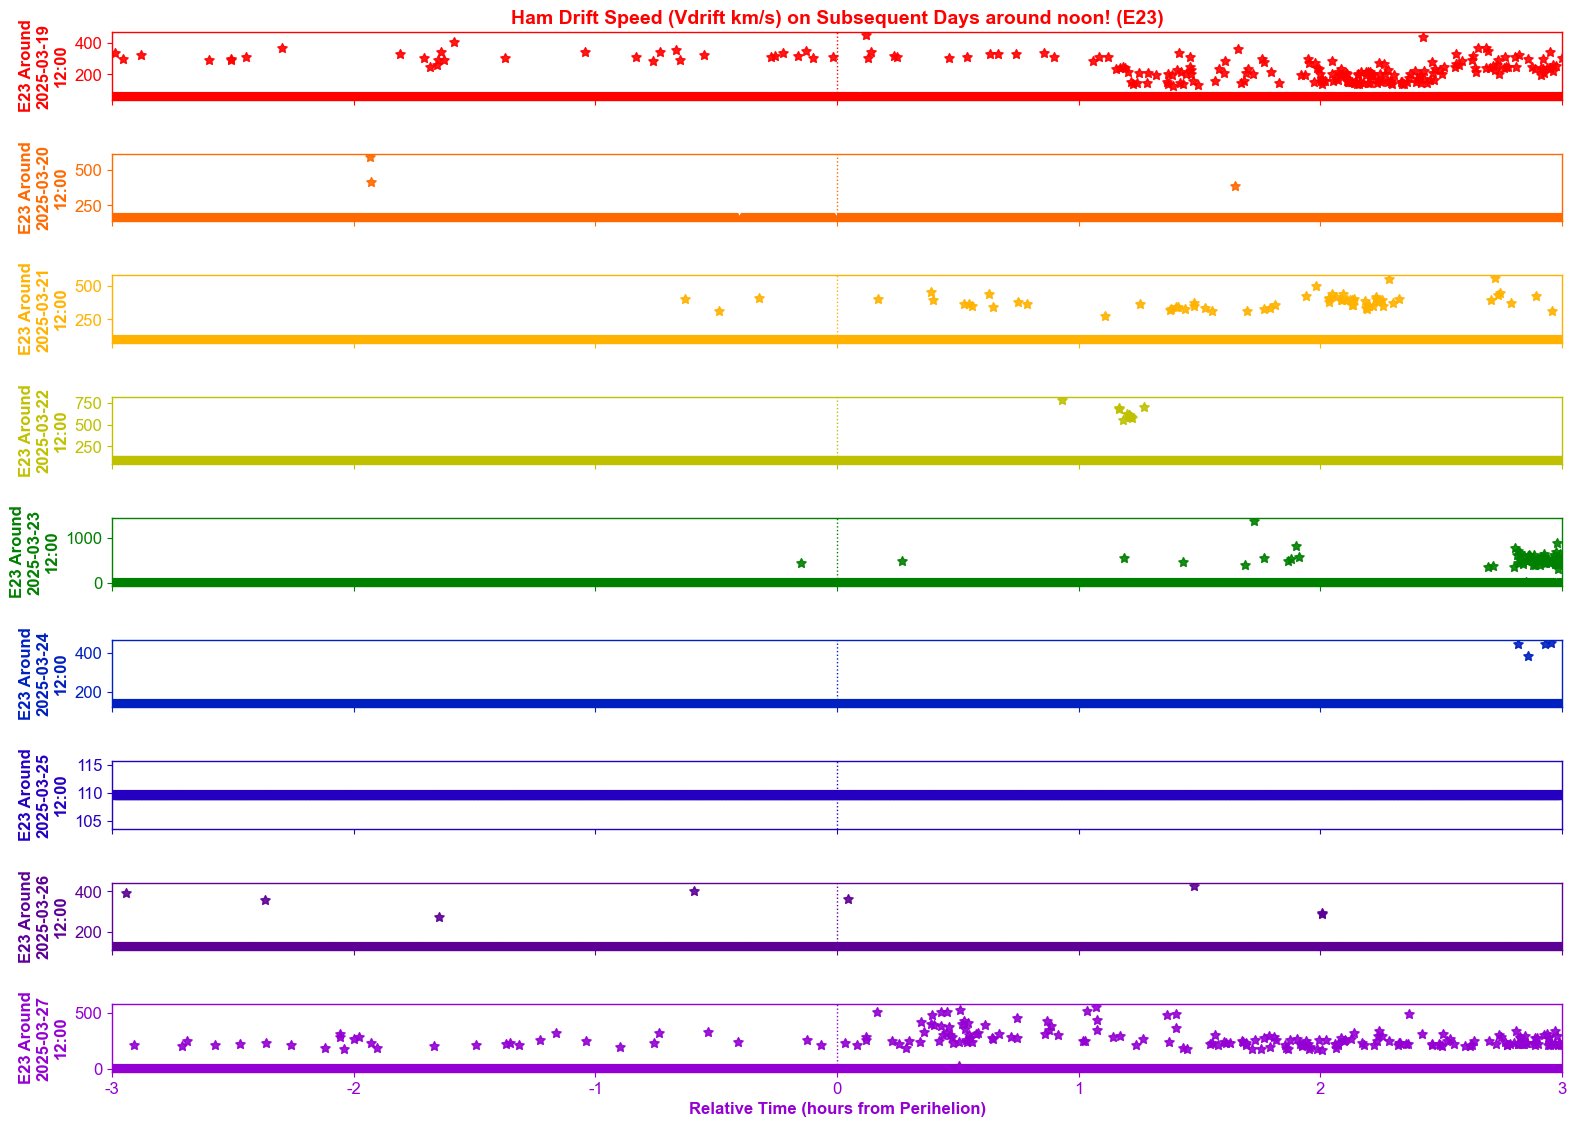

In [6]:
# REFORMATTED Example HAM 🍖 Multiplot Call for Ham/Core Drift Speed across Multiple Days around noon (using all the files you provided)

print("--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---")

# Only use the regular drift speed (not normalized)
ham_drift_vars = [
    ham.ham_core_drift  # Just the drift speed in km/s (not normalized by Alfven speed)
]

# Define ham noon times as a list of dictionaries
ham_noon_times = [
    {'time': '2025-03-19 12:00:00.000'},  # March 19th noon
    {'time': '2025-03-20 12:00:00.000'},  # March 20th noon
    {'time': '2025-03-21 12:00:00.000'},  # March 21st noon
    {'time': '2025-03-22 12:00:00.000'},  # March 22nd noon
    {'time': '2025-03-23 12:00:00.000'},  # March 23rd noon
    {'time': '2025-03-24 12:00:00.000'},  # March 24th noon
    {'time': '2025-03-25 12:00:00.000'},  # March 25th noon
    {'time': '2025-03-26 12:00:00.000'},  # March 26th noon
    {'time': '2025-03-27 12:00:00.000'},  # March 27th noon
]

# Create all plot tuples using list comprehension
all_plots = [(day['time'], var) for day in ham_noon_times for var in ham_drift_vars]

# --- Configure Plot Options ---
plt.options.reset() 

# Your existing plot parameters
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 14
plt.options.y_label_size = 12
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 12
plt.options.y_tick_label_size = 12
plt.options.y_label_pad = 4

plt.options.use_single_title = True
plt.options.single_title_text = 'Ham Drift Speed (Vdrift km/s) on Subsequent Days around noon! (E23)'
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = True

plt.options.window = '6:00:00'  # +/- 3 hours around noon
plt.options.position = 'around'
plt.options.draw_vertical_line = True

plt.options.color_mode = 'rainbow'
plt.options.single_color = None

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 1
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

# Generate the multiplot showing all days
fig, axs = multiplot(all_plots);

--- Generating Combined Multiplot ---


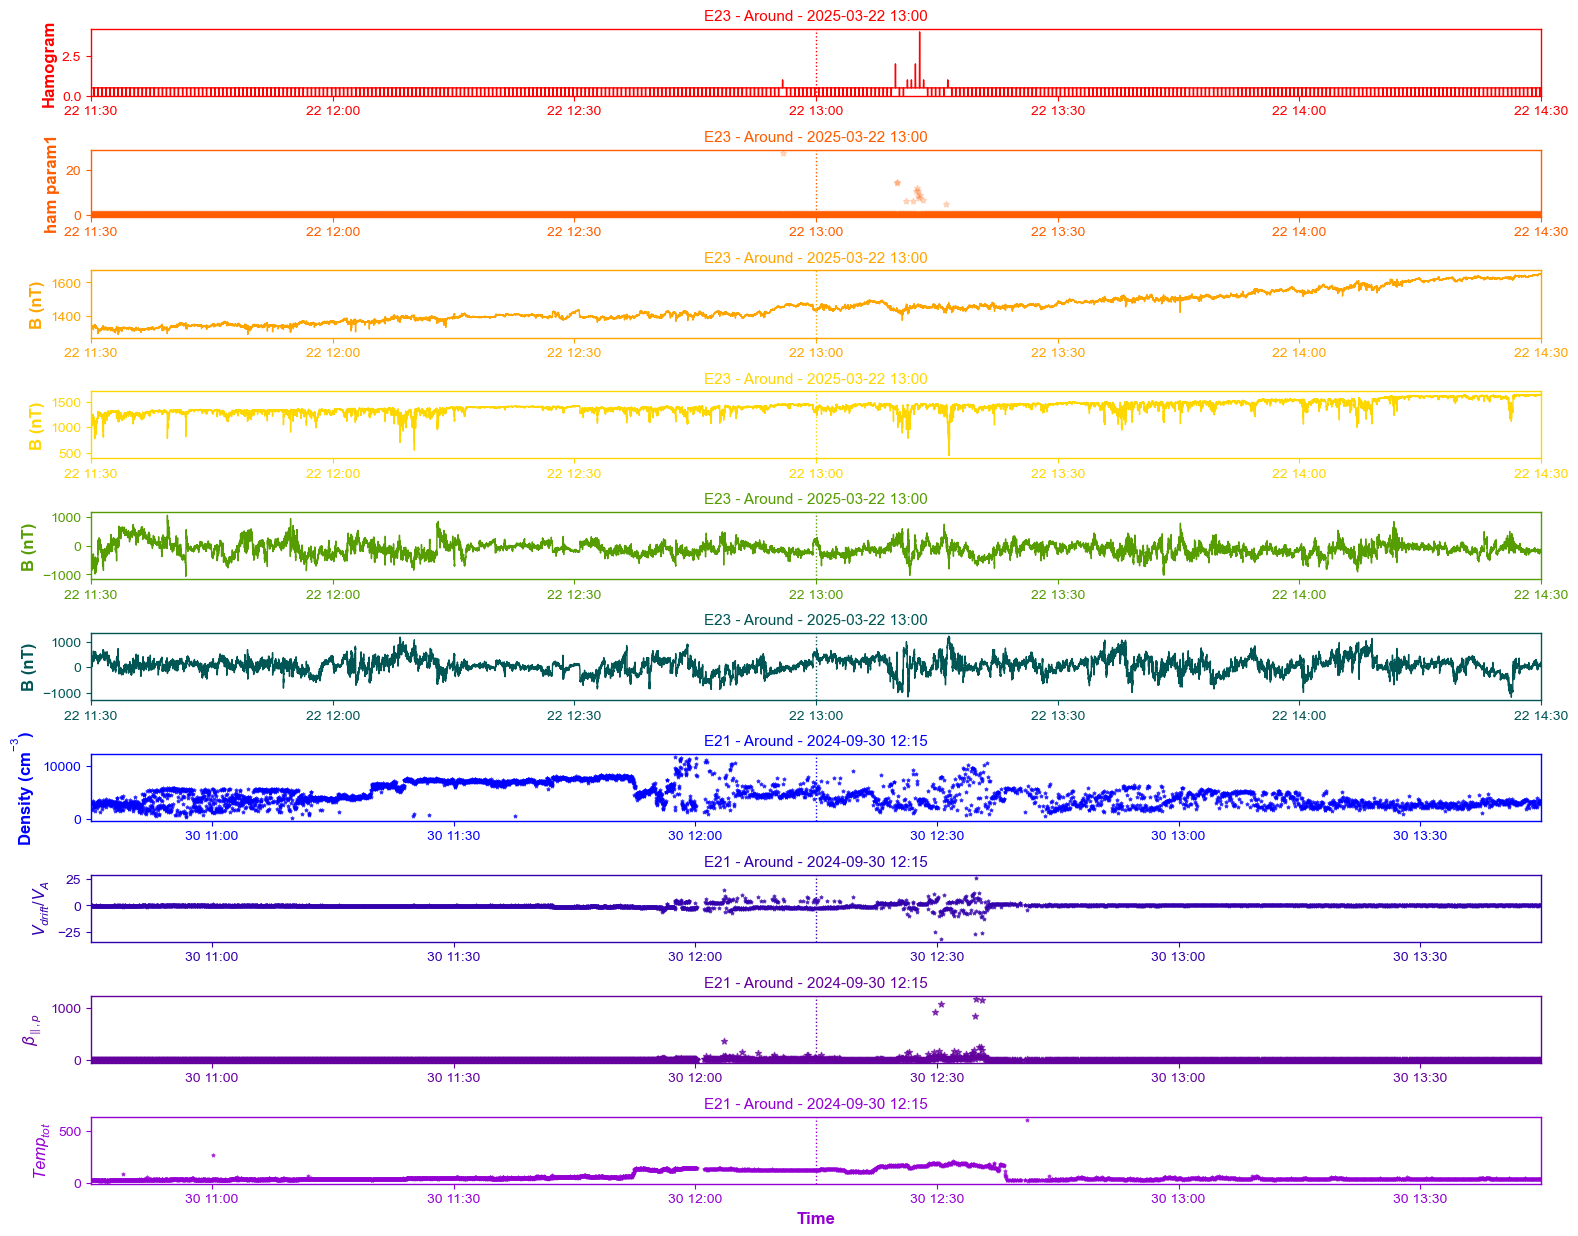


--- Combined multiplot example generated ---


In [ ]:
# Mixing it up and getting a lil' wild!

print("--- Generating Combined Multiplot ---")

ham_plot_time = '2025-03-22 13:00:00'  # Updated to use HAM date we know exists

# Define time for FITS data - use direct center time instead of calculation
fits_center_time_str = '2024-09-30 12:15:00'  # Simple midpoint of FITS test range

# --- Variables and Combined Plot Data ---
# List of variables for the Hammerhead section
plot1_vars = [
    ham.hamogram_30s,
    ham.Tperprat_driftva_hc,
    mag_rtn_4sa.bmag,
    mag_rtn_4sa.br,
    mag_rtn_4sa.bt,
    mag_rtn_4sa.bn
]

# List of FITS variables for the FITS section
plot2_vars = [
    proton_fits.np1,
    proton_fits.vdrift_va_pfits,
    proton_fits.beta_ppar_pfits,
    proton_fits.Temp_tot
]

# Create the combined plot data list:
# Associate HAM/Context vars with ham_plot_time
# Associate FITS vars with fits_center_time_str
plot_data_combined = (
    [(ham_plot_time, var) for var in plot1_vars] +
    [(fits_center_time_str, var) for var in plot2_vars]
)

# --- Configure Plot Options for Combined Plot ---
plt.options.reset() # Start fresh
plt.options.width = 16
# Adjust height per panel if needed for a taller plot
total_panels = len(plot_data_combined)
plt.options.height_per_panel = 1.2 # Slightly smaller height per panel for many panels
plt.options.use_single_title = False
plt.options.single_title_text = f"Combined Plot: HAMS ({ham_plot_time}) & FITS ({fits_center_time_str})"
# Window and position will be determined by the time point for each panel individually
plt.options.window = '3:00:00.000' # Default window, will apply to each panel's center time
plt.options.position = 'around'
plt.options.draw_vertical_line = True # Draw vertical line at the center time for each panel

# Disable rainbow for clarity on combined plot
plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 12
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 4

# plt.options.use_single_title = False
# plt.options.single_title_text = "Br Around PSP HCS Crossings"
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

# plt.options.draw_vertical_line = True
# plt.options.vertical_line_width = 1.5
# plt.options.vertical_line_color = 'red'
# plt.options.vertical_line_style = '--'

plt.options.use_relative_time = False
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None



# Generate the combined multiplot
# Multiplot will fetch data for EACH (time, variable) pair based on the specified time
multiplot(plot_data_combined)
# plt.show() # Keep plots displayed in notebook

print("\n--- Combined multiplot example generated ---")


TAplusBmag is not defined
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spi_sf00_l3_mom...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-28/06:00:00.000', '2023-09-28/

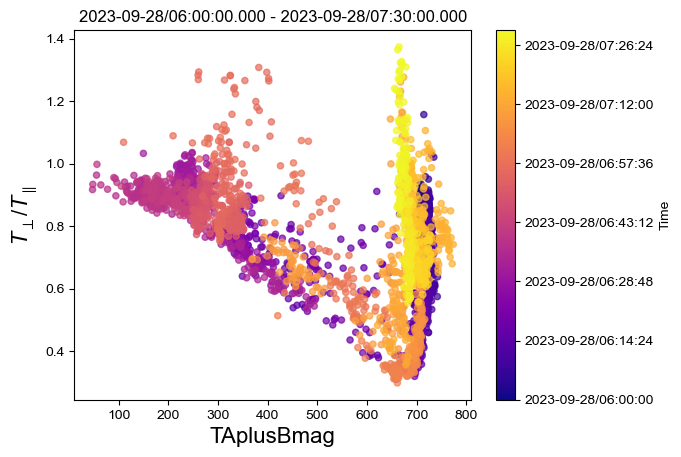

In [8]:
# # First define your time range for September 30, 2024 from 11:45 to 12:45
# trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

print_manager.show_status = True  # Status prints, ⭐️ useful for basic status updates

# Define a time range
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']
# trange = ['2023-10-28/06:00:00.000', '2023-10-28/07:30:00.000']

# print('CALLING GET DATA')

# get_data(trange, proton.anisotropy, mag_rtn_4sa.bmag)

# print('CALLED GET DATA')

# Create a custom variable with our elegant syntax
TAplusBmag = custom_variable('TAplusBmag', proton.anisotropy + mag_rtn_4sa.bmag)

# Print the length of TAplusBmag
try:
    print(f"Length of TAplusBmag: {len(TAplusBmag.data_array)}")
except:
    print("TAplusBmag is not defined")


# Then use showdahodo with proton.beta_ppar on x-axis and proton.anisotropy on y-axis
# showdahodo(trange, TAplusBmag, proton.anisotropy, brazil=True);
showdahodo(trange, TAplusBmag, proton.anisotropy);

📊 Operation complete: proton.anisotropy * mag_rtn_4sa.bmag
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spi_sf00_l3_mom...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

📊 Operation complete: proton.anisotropy * mag_rtn_4sa.bmag
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ -

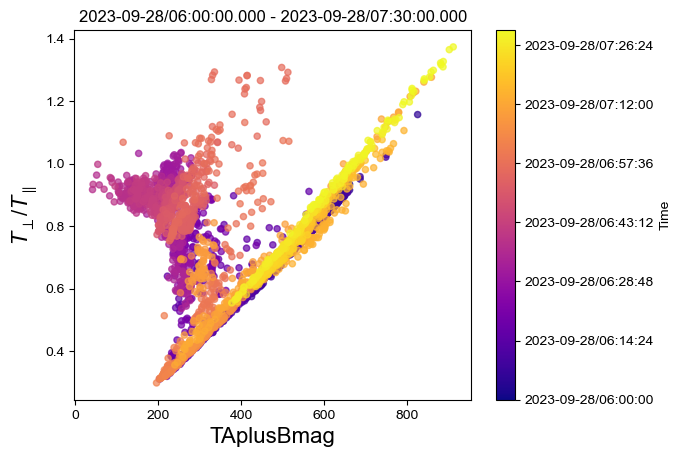

In [11]:
# # First define your time range for September 30, 2024 from 11:45 to 12:45
# trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

print_manager.show_status = True  # Status prints, ⭐️ useful for basic status updates

# Define a time range
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']
# trange = ['2023-10-28/06:00:00.000', '2023-10-28/07:30:00.000']

# Create a custom variable with our elegant syntax
TAplusBmag = custom_variable('TAplusBmag', proton.anisotropy * mag_rtn_4sa.bmag)

# Then use showdahodo with proton.beta_ppar on x-axis and proton.anisotropy on y-axis
# showdahodo(trange, TAplusBmag, proton.anisotropy, brazil=True);
showdahodo(trange, TAplusBmag, proton.anisotropy);

🛰️ mag_RTN_4sa - acquiring variables: bmag
🛰️ custom_data_type - acquiring variables: TAplusBmag
 
📤 Custom variable 'TAplusBmag' requires data for calculation
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spi_sf00_l3_mom...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: bmag
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_

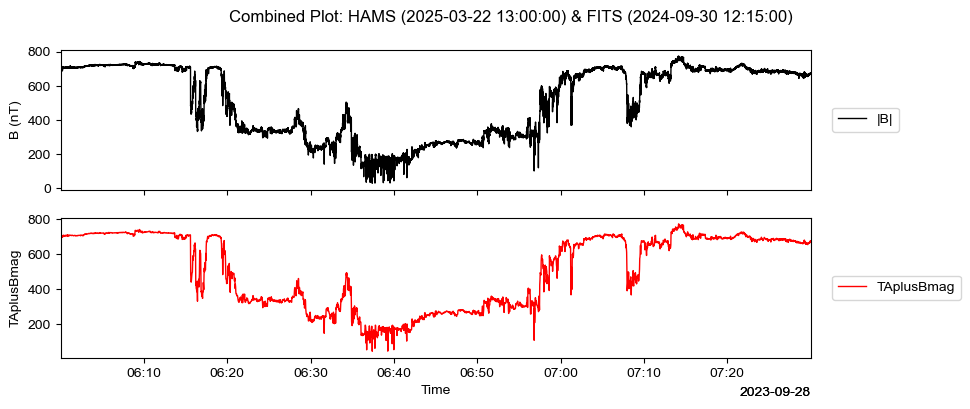

In [12]:
#Custom Variable Example!

print_manager.show_status = True  # Status prints, ⭐️ useful for basic status updates

# Define a time range
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']

# Create a custom variable with our elegant syntax
TAplusBmag = custom_variable('TAplusBmag', proton.anisotropy + mag_rtn_4sa.bmag)

# The variable is now globally accessible as TAoverBmag

# Customize the appearance of the custom variable
TAplusBmag.color = 'red'
TAplusBmag.line_style = '-'
TAplusBmag.line_width = 1
TAplusBmag.legend_label = 'Custom Label'

plotbot(trange, mag_rtn_4sa.bmag, 1, TAplusBmag, 2)

In [13]:
# STOP 😎 #Who's callin this guy invalid!?
# #This just makes the Run All command stop...

We're downloading a LOT of data here. This will take a while, but we only need to do it once and then we'll load from the local .cdf files!
Hold tight 🙏

Panel 1: Custom variable detected: AnisotropyMinusBmag
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230927_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-27/20:28:00.000000', '2023-09-28/02:28:00.000000'].

📥 Updating spi_sf00_l3_mom...
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230927_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-27/20:28:00.000000', '2023

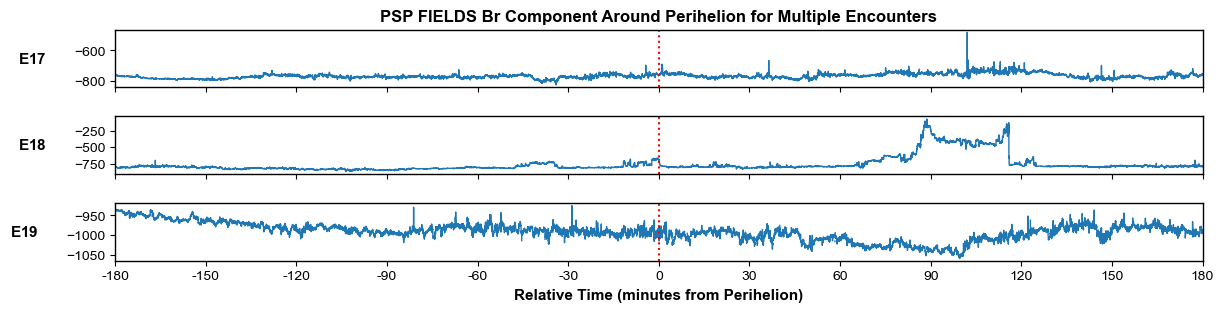

In [14]:
encounters = [

    {'perihelion': '2023/09/27 23:28:00.000'}, #Enc 17
    {'perihelion': '2023/12/29 00:56:00.000'}, #Enc 18
    {'perihelion': '2024/03/30 02:21:00.000'}, #Enc 19 

]

#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

plt.options.reset() # Resetting options to ensure a clean slate

# Plot Setup
plt.options.width = 15
plt.options.height_per_panel = 1

plt.options.use_single_title = True
plt.options.single_title_text = "PSP FIELDS Br Component Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'minutes'
plt.options.relative_time_step = 30

# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
# plt.options.color_mode = 'default'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = None     # Used when color_mode = 'single'

# DATA SELECTION FOR PLOTTING
plt.options.window = '6:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']

plot_manager.interp_method = 'nearest'
AnisotropyMinusBmag = custom_variable('AnisotropyMinusBmag', proton.anisotropy - mag_rtn_4sa.bmag)

# plot_variable = mag_rtn_4sa.br
plot_variable = AnisotropyMinusBmag

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
print("We're downloading a LOT of data here. This will take a while, but we only need to do it once and then we'll load from the local .cdf files!")
print("Hold tight 🙏\n")
multiplot(plot_data);

📊 Operation complete: mag_rtn_4sa.br * mag_rtn_4sa.bt
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
🛰️ custom_data_type - acquiring variables: TAoverBr, NewVar
 
📤 Custom variable 'TAoverBr' requires data for calculation
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: br
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spi_sf00_l3_mom...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

📤 Custom variable 'NewVar' requires data for 

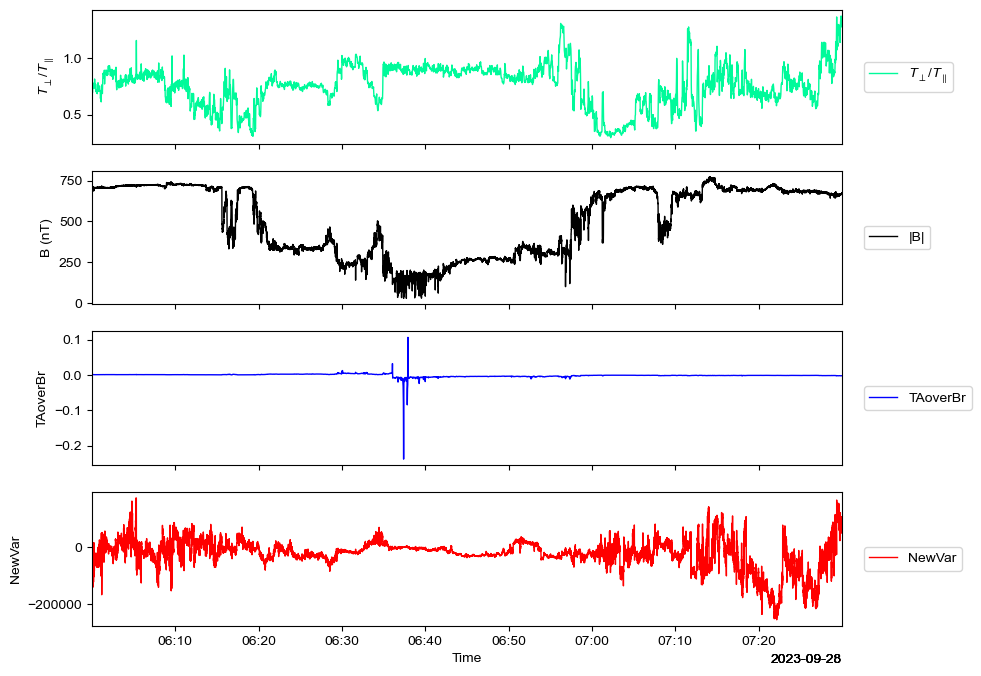

In [15]:
plt.options.reset() # Resetting options to ensure a clean slate

# Import data
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']
# get_data(trange, mag_rtn_4sa.bmag, proton.anisotropy)


# Switch back if needed
plot_manager.interp_method = 'nearest'

TAoverBr = custom_variable('TAoverBr', proton.anisotropy / mag_rtn_4sa.br )

TAoverBr.color = 'blue'

NewVar = custom_variable('NewVar', mag_rtn_4sa.br * mag_rtn_4sa.bt)

# Set the color of the new variable
NewVar.color = 'red'

# Plot the new variable on the fourth panel
plotbot(trange, proton.anisotropy, 1, mag_rtn_4sa.bmag, 2, TAoverBr, 3, NewVar, 4)
# multiplot([(trange, proton.anisotropy), (trange, mag_rtn_4sa.bmag), (trange, TAoverB), (trange, NewVar)])


In [16]:
# Import the test runner
# from plotbot.test_pilot import run_missions

# # Run the tests with our space-themed output
# # run_missions("tests.test_custom_variables")
# import pytest
# pytest.main(["-v", "tests/test_custom_variables.py"])
# pytest.main(["-v", "tests/test_custom_variable_operators.py"])
# pytest.main(["-v", "tests/test_multiplot.py"])
# pytest.main(["-v", "tests/test_plotbot.py"])
# pytest.main(["-v", "tests/test_global.py"])


In [17]:
# STOP 😎 #Who's callin this guy invalid!?
# #This just makes the Run All command stop...

📊 Operation complete: mag_rtn_4sa.bmag * 100
   → No interpolation needed for scalar operation

🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
 
🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
🛰️ mag_RTN_4sa - acquiring variables: bmag
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spi_sf00_l3_mom...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

📈 Plotting proton.anisotropy
📈 Plotting mag_rtn_4sa.bmag


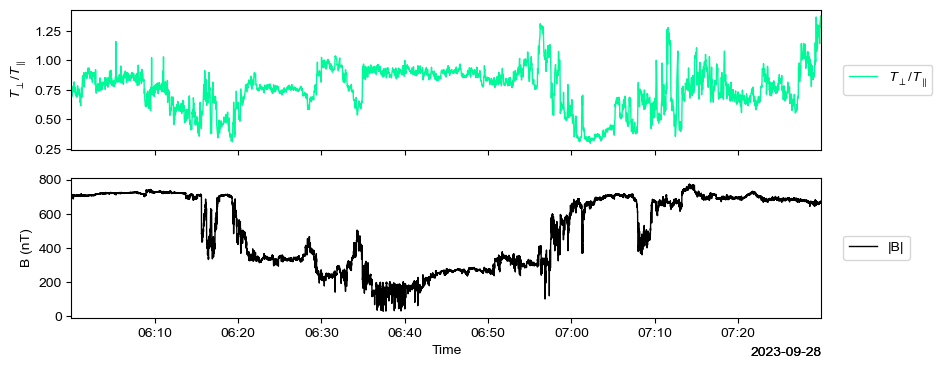

In [18]:
plt.options.reset() # Resetting options to ensure a clean slate

# Set print manager settings for status, debug, and variable testing
# print_manager.show_status = True
# print_manager.show_debug = False
# print_manager.show_variable_testing = True

# Configure server access username
server_access.username = None  # Prompt for username if None, or set 'your_username' to hardcode

# Define time range for plotting
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing

# Create a scaled version of bmag and set its color

print_manager.variable_testing("Storing bmag100x")
# Store the scaled bmag data
bmag100x = custom_variable('bmag100x', mag_rtn_4sa.bmag * 100)

bmag100x.color = 'red'

print_manager.variable_testing("Initializing plotbot with bmag100x on the third axis")

# Plot bmag and its scaled version
# plotbot(trange, mag_rtn_4sa.bmag, 1, bmag100x, 2)

# Calculate and store TAoverB

# print_manager.variable_testing("defining TAoverBmag")
# TAoverBmag = proton.anisotropy + mag_rtn_4sa.bmag

# TAoverBmag.color = 'red'
# TAoverBmag.y_label = 'TAoverBmag'
# TAoverBmag.name = 'TAoverBmag'

# print_manager.variable_testing("Storing TAoverB")
# store_data('TAoverB', data={'x': proton.anisotropy.datetime_array, 'y': TAoverBmag})
# TAoverB = new_variable(TAoverBmag, 'TAoverB')
# new_variable('Hello', proton.anisotropy + mag_rtn_4sa.bmag)

# Hello.color = 'red'

# Plot anisotropy, bmag, and TAoverB
print_manager.variable_testing("Initializing plotbot with TAoverB on the third axis")
plotbot(trange, proton.anisotropy, 1, mag_rtn_4sa.bmag, 2)# Hello, 3)


In [19]:

# # Set print manager settings for status, debug, and variable testing
# print_manager.show_status = True
# print_manager.show_debug = False
# print_manager.show_variable_testing = True

# # Configure server access username
# server_access.username = None  # Prompt for username if None, or set 'your_username' to hardcode

# # Define time range for plotting
# trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing

# # Plot bmag and its scaled version
# plotbot(trange, mag_rtn_4sa.bmag, 1, proton.anisotropy, 2)

# # Create a scaled version of bmag and set its color
# bmag100x_data = mag_rtn_4sa.bmag * 100
# # Plot bmag and its scaled version
# plotbot(trange, mag_rtn_4sa.bmag, 1, bmag100x, 2)

# # Calculate and store TAoverB

# print_manager.variable_testing("defining TAoverBmag")
# TAoverBmag = proton.anisotropy / mag_rtn_4sa.bmag

# print_manager.variable_testing("Storing TAoverB")
# store_data('TAoverB', data={'x': proton.anisotropy.datetime_array, 'y': TAoverBmag})

# # Plot anisotropy, bmag, and TAoverB
# print_manager.variable_testing("Initializing plotbot with TAoverB on the third axis")
# plotbot(trange, proton.anisotropy, 1, mag_rtn_4sa.bmag, 2, TAoverBmag, 3)


🛰️ spe_sf0_pad - acquiring variables: strahl
🛰️ mag_RTN_4sa - acquiring variables: br, bmag, bt, bn
 
🛰️ spe_sf0_pad - acquiring variables: strahl
🛰️ mag_RTN_4sa - acquiring variables: br, bmag, bt, bn
📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2023/psp_swp_spe_sf0_L3_pad_20230928_v04.cdf
✅ - CDF Data import complete for spe_sf0_pad range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spe_sf0_pad...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

📈 Plotting mag_rtn_4sa.br
📈 Plotting mag_rtn_4sa.bmag
📈 Plotting mag_rtn_4sa.bt
📈 Plotting mag_rtn_4sa.bn
📈 Plotting epad.strahl


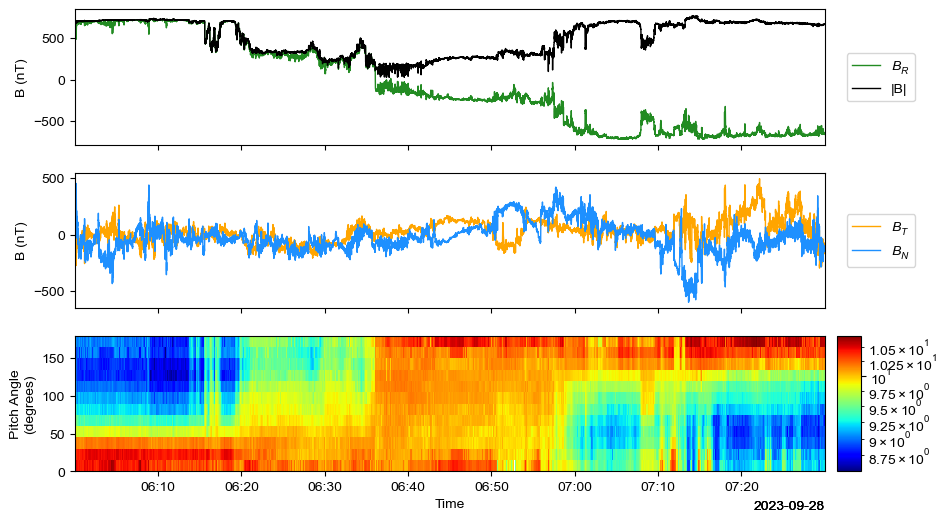

In [20]:
plt.options.reset() # Resetting options to ensure a clean slate
#E17 HCS Crossing

# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging
# print_manager.show_variable_testing = True

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

epad.strahl.colorbar_limits = 'default'
epad.strahl.colorbar_scale = 'log'

trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing
plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
        mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
        epad.strahl, 3)



# Uncomment to add proton data! Note: You'll need a username and password for server access.
# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1,  
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, 8)

🛰️ mag_RTN_4sa - acquiring variables: br
 
🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2024/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20240929_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2024-09-29/12:10:00.000', '2024-09-29/12:11:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

📈 Plotting mag_rtn_4sa.br


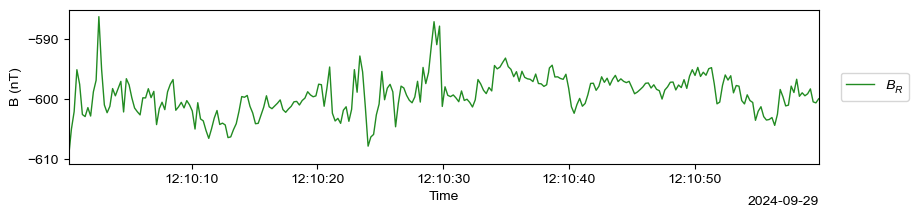

In [21]:
# trange = ['2024-09-30/12:10:00.000', '2024-09-30/12:11:00.000']

plt.options.reset() # Resetting options to ensure a clean slate

trange = ['2024-09-29/12:10:00.000', '2024-09-29/12:11:00.000']

plotbot(trange, mag_rtn_4sa.br, 1)

### Showdahodo

✨ We can use the showdahodo function to plot two variables against each other, like the radial magnetic field and strahl centroids!

🛰️ spe_sf0_pad - acquiring variables: centroids
🛰️ mag_RTN_4sa - acquiring variables: br
📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2023/psp_swp_spe_sf0_L3_pad_20230928_v04.cdf
✅ - CDF Data import complete for spe_sf0_pad range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating spe_sf0_pad...
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete



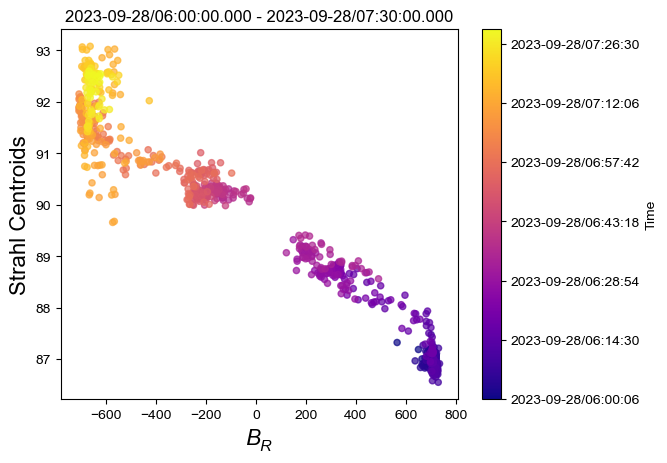

In [22]:
#----Print manager----///
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

#----Showdahodo----///
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing

print("✨ We can use the showdahodo function to plot two variables against each other, like the radial magnetic field and strahl centroids!\n")

showdahodo(trange, mag_rtn_4sa.br, epad.centroids);

🛰️ spi_sf00_l3_mom - acquiring variables: beta_ppar, anisotropy
📡 spi_sf00_l3_mom - A local .cdf file already exists:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240930_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000'].

📥 Updating spi_sf00_l3_mom...
✅ Data acquisition complete



/Users/robertalexander/GitHub/Plotbot/plotbot/showdahodo.py:538: RuntimeWarning: invalid value encountered in power
  trat_parfire = 1-(.47/(beta_par - .59)**.53)


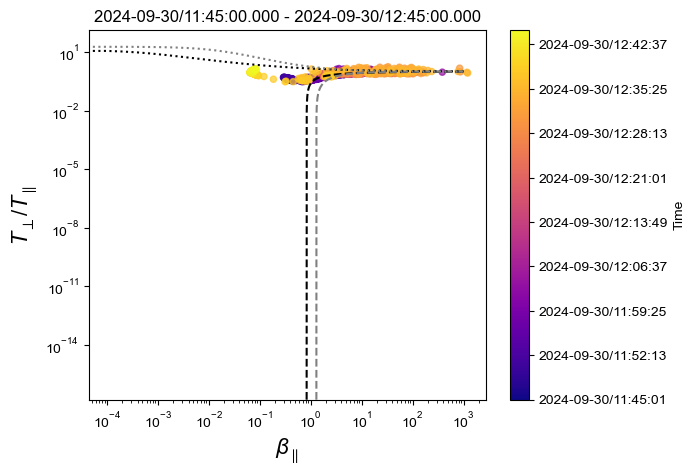

In [23]:
# First define your time range for September 30, 2024 from 11:45 to 12:45
trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

proton.beta_ppar.y_scale = 'log'
proton.anisotropy.y_scale = 'log'

# Then use showdahodo with proton.beta_ppar on x-axis and proton.anisotropy on y-axis
showdahodo(trange, proton.beta_ppar, proton.anisotropy, brazil=True);

In [24]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/12:10:00.000', '2024-09-30/12:20:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, 8)

### Multiplot

In [25]:
#We can define a separate list of encounters to plot, or continue to use the rainbow_encounters list!
encounters = [
    # {'perihelion': '2018/11/06 03:27:00.000'}, #Enc 1
    # {'perihelion': '2019/04/04 22:39:00.000'}, #Enc 2
    # {'perihelion': '2019/09/01 17:50:00.000'}, #Enc 3
    # {'perihelion': '2020/01/29 09:37:00.000'}, #Enc 4
    # {'perihelion': '2020/06/07 08:23:00.000'}, #Enc 5
    # {'perihelion': '2020/09/27 09:16:00.000'}, #Enc 6
    # {'perihelion': '2021/01/17 17:40:00.000'}, #Enc 7
    # {'perihelion': '2021/04/29 08:48:00.000'}, #Enc 8
    # {'perihelion': '2021/08/09 19:11:00.000'}, #Enc 9
    # {'perihelion': '2021/11/21 08:23:00.000'}, #Enc 10
    # {'perihelion': '2022/02/25 15:38:00.000'}, #Enc 11
    # {'perihelion': '2022/06/01 22:51:00.000'}, #Enc 12
    # {'perihelion': '2022/09/06 06:04:00.000'}, #Enc 13
    # {'perihelion': '2022/12/11 13:16:00.000'}, #Enc 14
    # {'perihelion': '2023/03/17 20:30:00.000'}, #Enc 15
    # {'perihelion': '2023/06/22 03:46:00.000'}, #Enc 16
    {'perihelion': '2023/09/27 23:28:00.000'}, #Enc 17
    {'perihelion': '2023/12/29 00:56:00.000'}, #Enc 18
    {'perihelion': '2024/03/30 02:21:00.000'}, #Enc 19 
    # {'perihelion': '2024/06/30 03:47:00.000'}, #Enc 20 Not yet publicly available
    # {'perihelion': '2024/09/30 05:15:00.000'}, #Enc 21 Not yet publicly available
    # {'perihelion': '2024/12/24 11:53:00.000'}, #Enc 22 Not yet publicly available
]

In [26]:
# # Create an empty list to store plot data
# plot_data = []

# # Process each encounter
# for i, encounter in enumerate(encounters):
#     # Get data for this time range
#     trange = [encounter['rangeStart'], encounter['rangeStop']]
#     get_data(trange, mag_rtn_4sa.bmag, proton.anisotropy)
    
#     # Create derived variable
#     TAoverBmag = proton.anisotropy / mag_rtn_4sa.bmag 
    
#     # Store with unique name
#     enc_num = i + 1  # Encounter number (1-based)
#     unique_name = f"TAoverBmag_E{enc_num}"
#     store_data(unique_name, data={'x': TAoverBmag.datetime_array, 'y': TAoverBmag})
    
#     # Add to plot data using the uniquely stored variable
#     # We reference the variable by its new name
#     derived_var = eval(unique_name)  # This works because it was made globally accessible
#     plot_data.append((encounter['perihelion'], derived_var))



# # Plot everything
# multiplot(plot_data);

We're downloading a LOT of data here. This will take a while, but we only need to do it once and then we'll load from the local .cdf files!
Hold tight 🙏

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230926_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230927_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-26/23:28:00.000000', '2023-09-28/23:28:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20231228_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20231229_v02.cdf, psp_data/fields/l2/mag_rtn

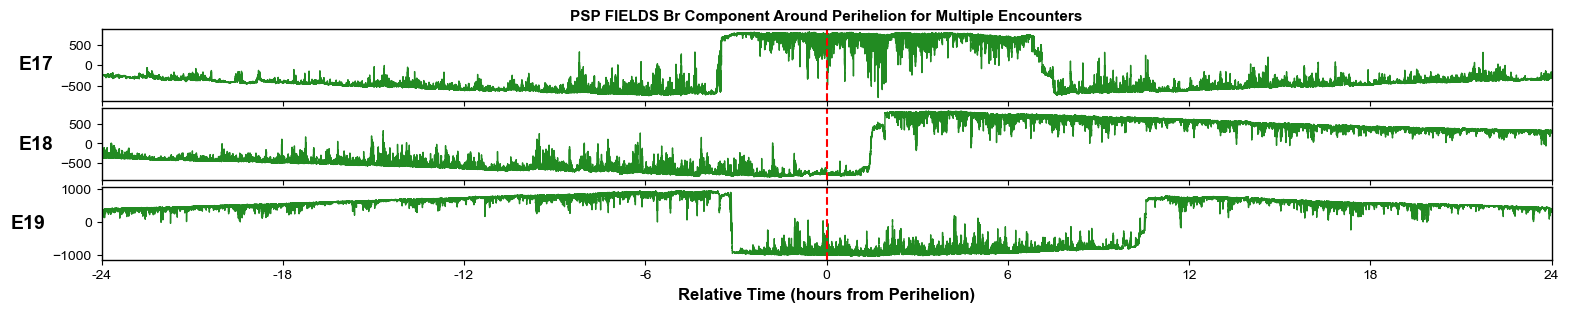

In [27]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

# print_manager.show_variable_testing = True
# print_manager.show_variable_basic = True

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 1
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP FIELDS Br Component Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax1.y_limit = (-3000, 3000)  # Example y-limit for ax1
# plt.options.ax3.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
plt.options.color_mode = 'default'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '48:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = mag_rtn_4sa.br


# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
print("We're downloading a LOT of data here. This will take a while, but we only need to do it once and then we'll load from the local .cdf files!")
print("Hold tight 🙏\n")
multiplot(plot_data);

In [28]:
#define a set of encounters to plot
rainbow_encounters = [
    # {'perihelion': '2018/11/06 03:27:00.000'}, #Enc 1
    # {'perihelion': '2019/04/04 22:39:00.000'}, #Enc 2
    # {'perihelion': '2019/09/01 17:50:00.000'}, #Enc 3
    # {'perihelion': '2020/01/29 09:37:00.000'}, #Enc 4
    # {'perihelion': '2020/06/07 08:23:00.000'}, #Enc 5
    # {'perihelion': '2020/09/27 09:16:00.000'}, #Enc 6
    # {'perihelion': '2021/01/17 17:40:00.000'}, #Enc 7
    # {'perihelion': '2021/04/29 08:48:00.000'}, #Enc 8
    # {'perihelion': '2021/08/09 19:11:00.000'}, #Enc 9
    # {'perihelion': '2021/11/21 08:23:00.000'}, #Enc 10
    # {'perihelion': '2022/02/25 15:38:00.000'}, #Enc 11
    # {'perihelion': '2022/06/01 22:51:00.000'}, #Enc 12
    # {'perihelion': '2022/09/06 06:04:00.000'}, #Enc 13
    # {'perihelion': '2022/12/11 13:16:00.000'}, #Enc 14
    # {'perihelion': '2023/03/17 20:30:00.000'}, #Enc 15
    # {'perihelion': '2023/06/22 03:46:00.000'}, #Enc 16
    {'perihelion': '2023/09/27 23:28:00.000'}, #Enc 17
    {'perihelion': '2023/12/29 00:56:00.000'}, #Enc 18
    {'perihelion': '2024/03/30 02:21:00.000'}, #Enc 19 
    # {'perihelion': '2024/06/30 03:47:00.000'}, #Enc 20 Not yet publicly available
    # {'perihelion': '2024/09/30 05:15:00.000'}, #Enc 21 Not yet publicly available
    # {'perihelion': '2024/12/24 11:53:00.000'}, #Enc 22 Not yet publicly available
]

🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230925_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230926_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230927_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230928_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20230929_v04.cdf
✅ - CDF Data import complete for spi_sf00_l3_mom range ['2023-09-25/23:28:00.000000', '2023-09-29/23:28:00.000000'].

📥 Updating spi_sf00_l3_mom...
✅ Data acquisition complete

🛰️ spi_sf00_l3_mom - acquiring variables: anisotropy
📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20231227_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2023/psp_swp_spi_sf00_L3_mom_20231228_v04.cdf, psp_data/sweap/

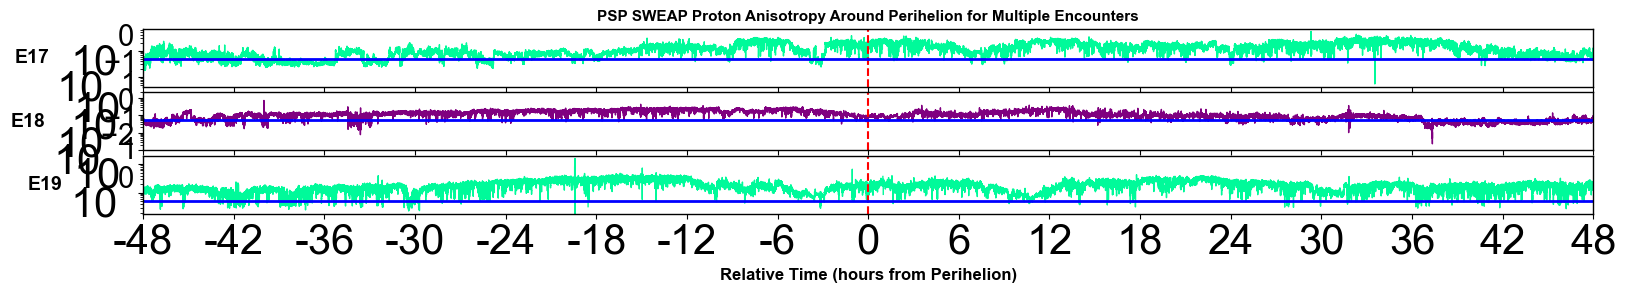

In [29]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 0.8
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12

# plt.options.x_tick_label_size = 10
# plt.options.y_tick_label_size = 10

plt.options.x_tick_label_size = 30
plt.options.y_tick_label_size = 30

plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP SWEAP Proton Anisotropy Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
plt.options.ax2.y_limit = (0.01, 20)  # Example y-limit for ax2
# Access each axis to ensure it is initialized, then set the y_limit
# for i in range(1, 4): #To properly plot the final desired axis, use the last axis number + 1 for the end range!
#     axis_attr = f'ax{i}'
#     axis_options = getattr(plt.options, axis_attr)  # This will initialize the axis if it doesn't exist
#     axis_options.y_limit = (0, 10)  # Set y-limit for axes 1 through 22

plt.options.ax2.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
# plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'


#====================================================================
# Draw a horizontal line at a specific value!
#====================================================================
plt.options.draw_horizontal_line = True
plt.options.horizontal_line_value = 0.5
plt.options.horizontal_line_color = 'blue'
plt.options.horizontal_line_width = 2
plt.options.horizontal_line_style = '-'
plt.options.border_line_width = 1

# # Axis-specific horizontal line
# plt.options.ax1.draw_horizontal_line = True
# plt.options.ax1.horizontal_line_value = 2.0
# plt.options.ax1.horizontal_line_color = 'green'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '96:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = proton.anisotropy #You'll need server access to plot this variable!

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
# multiplot(plot_data); #You'll need server access to plot this variable! ✨Un-comment to Plot! 

# Add this after calling multiplot
fig, axs = multiplot(plot_data)
    


Bring the magic 🌈
🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230926_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230927_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20230928_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-09-26/23:28:00.000000', '2023-09-28/23:28:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20231228_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20231229_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2023/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20231230_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2023-12-28/00:56

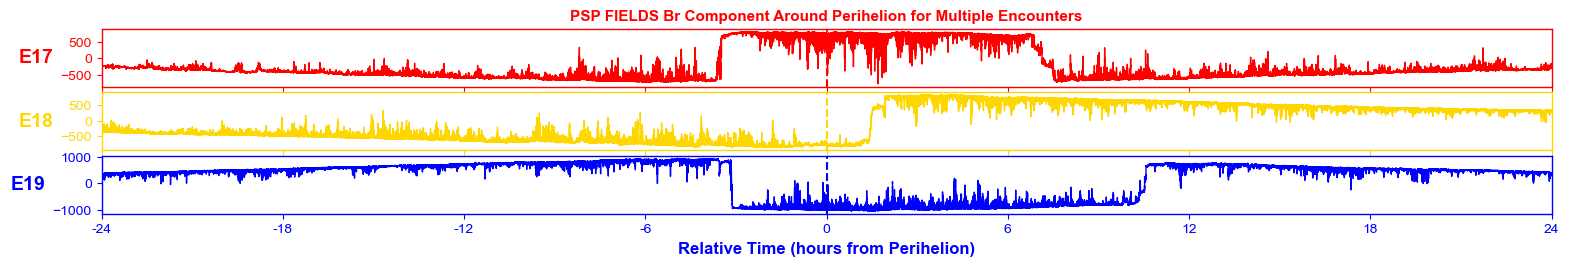

In [30]:
#######-----🌈🌈🌈🌈🌈🌈 MULTIPLOTTING Rainbow MAGIC 🌈🌈🌈🌈🌈----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 0.8
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP FIELDS Br Component Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax1.y_limit = (-3000, 3000)  # Example y-limit for ax1
# plt.options.ax3.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '48:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = mag_rtn_4sa.br

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
print("Bring the magic 🌈")

multiplot(plot_data);

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210428_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210429_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2021-04-28/22:00:00.000000', '2021-04-29/04:00:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210429_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2021-04-29/05:20:00.000000', '2021-04-29/11:20:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210429_v02.cdf
✅ - CDF Data

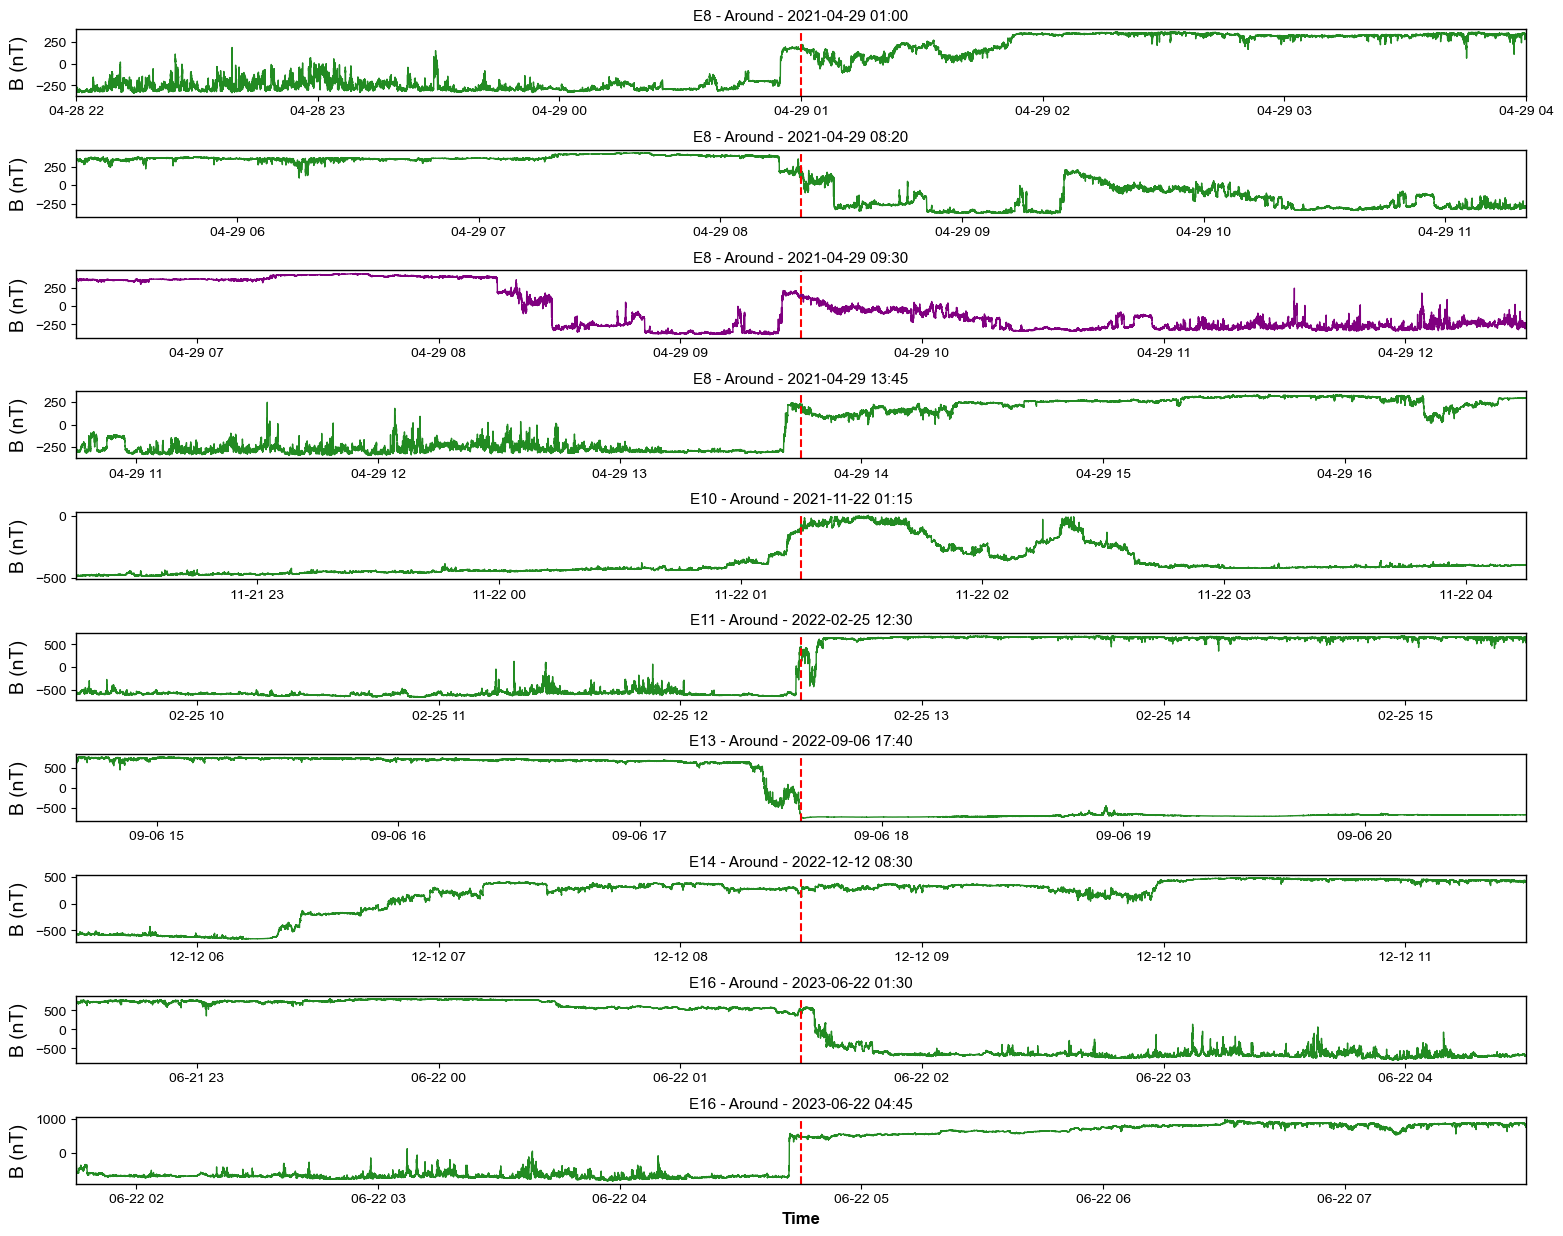

In [31]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = False
plt.options.single_title_text = "Br Around PSP HCS Crossings"
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = False
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax1.y_limit = (-3000, 3000)  # Example y-limit for ax1
plt.options.ax3.color = 'purple'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================
hcs_crossing_times = [ #in the previous example we defined the times outside the cell, either way works!
    '2021-04-29/01:00:00.000',
    '2021-04-29/08:20:00.000',
    '2021-04-29/09:30:00.000',
    '2021-04-29/13:45:00.000',
    '2021-11-22/01:15:00.000',
    '2022-02-25/12:30:00.000',
    '2022-09-06/17:40:00.000',
    '2022-12-12/08:30:00.000',
    '2023-06-22/01:30:00.000',
    '2023-06-22/04:45:00.000'
]

plt.options.window = '06:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = mag_rtn_4sa.br

# Create the plot data list using list comprehension
plot_data = [(time, plot_variable) for time in hcs_crossing_times]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data); #✨Un-comment to Plot! 

🛰️ spe_sf0_pad - acquiring variables: strahl
📡 spe_sf0_pad - Local .cdf files already exist:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210428_v04.cdf, psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - CDF Data import complete for spe_sf0_pad range ['2021-04-28/22:00:00.000000', '2021-04-29/04:00:00.000000'].

📥 Updating spe_sf0_pad...
✅ Data acquisition complete

🛰️ spe_sf0_pad - acquiring variables: strahl
📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - CDF Data import complete for spe_sf0_pad range ['2021-04-29/05:20:00.000000', '2021-04-29/11:20:00.000000'].

📥 Updating spe_sf0_pad...
✅ Data acquisition complete

🛰️ spe_sf0_pad - acquiring variables: strahl
📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - CDF Data import complete for spe_sf0_pad range ['202

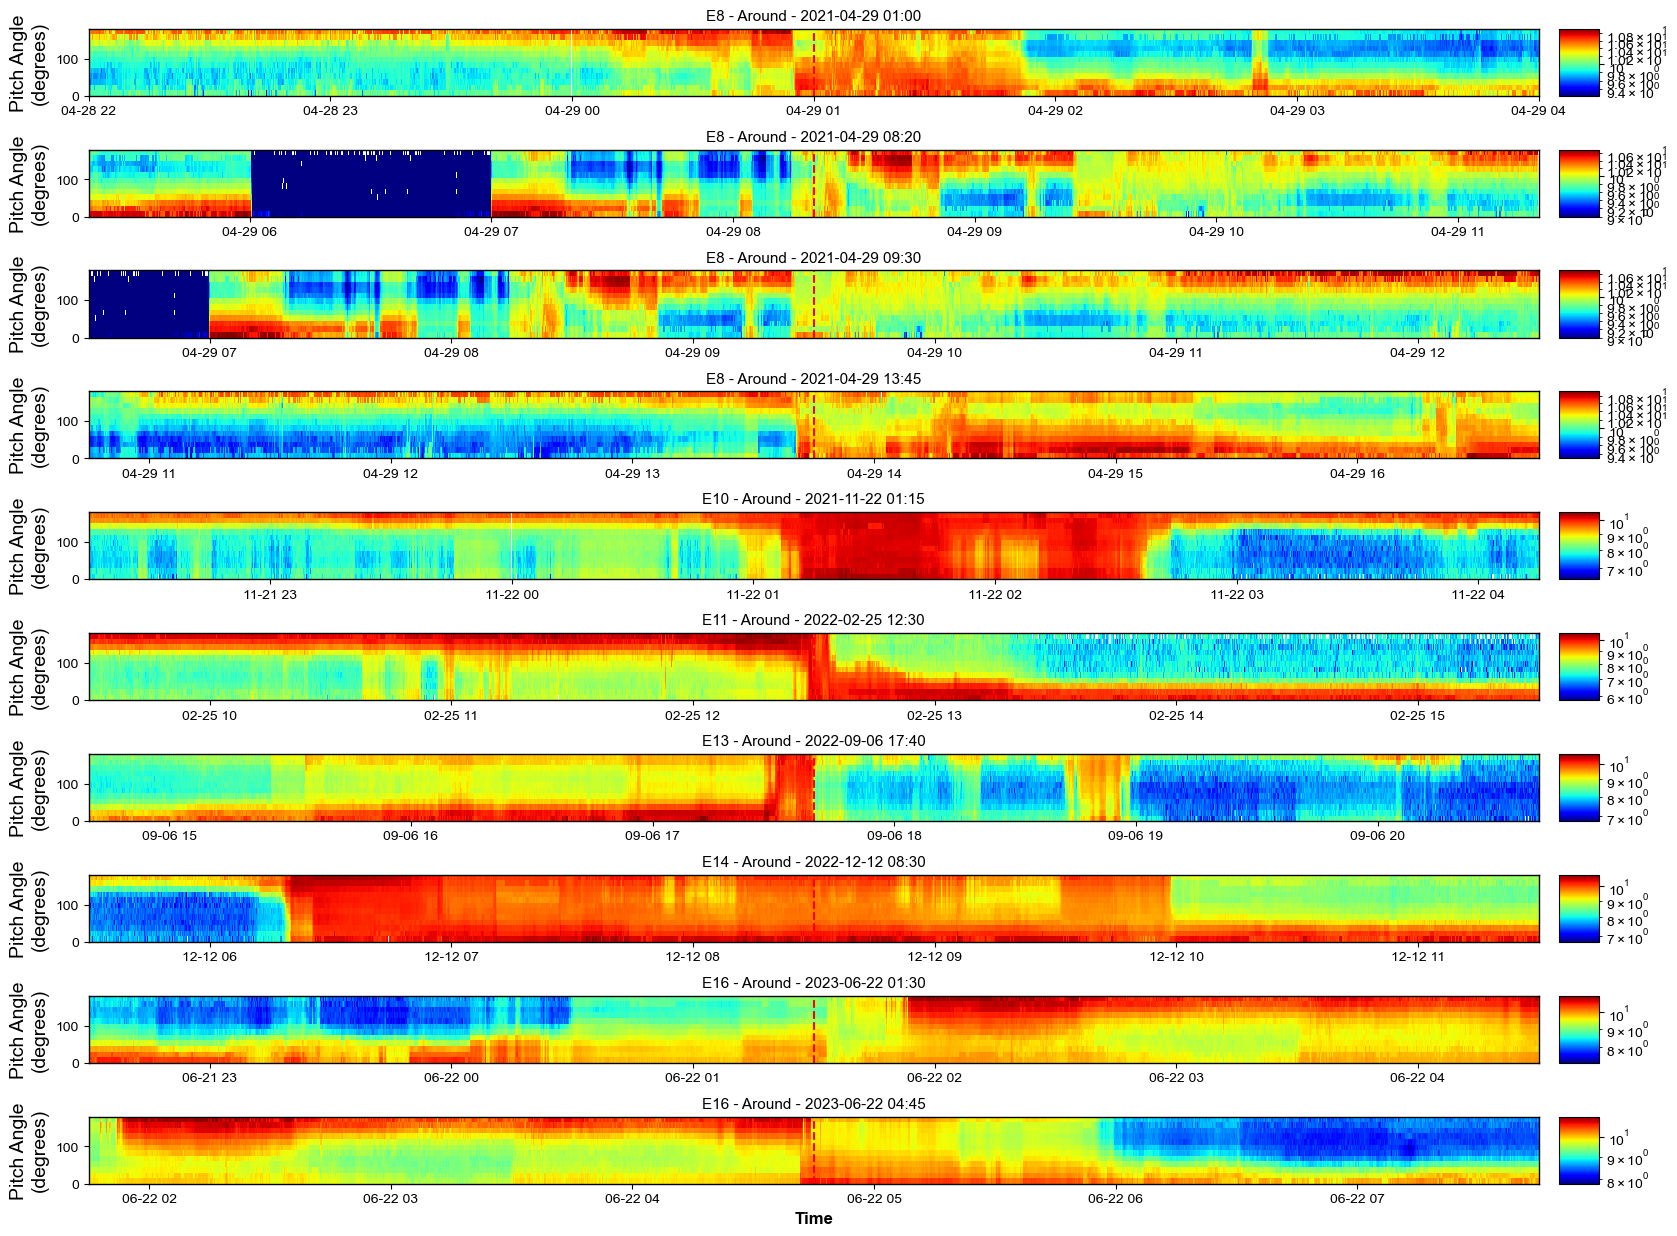

In [32]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC - STRAHL EXAMPLE 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================

# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = False
plt.options.single_title_text = "Br Around PSP HCS Crossings"
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = False
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
plt.options.ax2.colorbar_limits = (9, 10.7) #We're setting a custom limit to correct for the area where the instrument dropped out.
plt.options.ax3.colorbar_limits = (9, 10.7) #This causes the drop-out region to appear dark blue, but the rest of the data is properly scaled.

#====================================================================
# Ploptions work too!
#====================================================================
epad.strahl.colorbar_limits = 'default' #Setting to default in case this was changed elsewhere... it gets overriden by the axis specific option for ax2 and ax3!

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================
hcs_crossing_times = [ #in the previous example we defined the times outside the cell, either way works!
    '2021-04-29/01:00:00.000',
    '2021-04-29/08:20:00.000',
    '2021-04-29/09:30:00.000',
    '2021-04-29/13:45:00.000',
    '2021-11-22/01:15:00.000',
    '2022-02-25/12:30:00.000',
    '2022-09-06/17:40:00.000',
    '2022-12-12/08:30:00.000',
    '2023-06-22/01:30:00.000',
    '2023-06-22/04:45:00.000'
]

plt.options.window = '06:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = epad.strahl

# Create the plot data list using list comprehension
plot_data = [(time, plot_variable) for time in hcs_crossing_times]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data); #✨Un-comment to Plot! 

In [33]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 0.8
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP SWEAP Proton Anisotropy Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax4.y_limit = (0, 5)  # Example y-limit for ax1
# Access each axis to ensure it is initialized, then set the y_limit
for i in range(11, 16): #To properly plot the final desired axis, use the last axis number + 1 for the end range!
    axis_attr = f'ax{i}'
    axis_options = getattr(plt.options, axis_attr)  # This will initialize the axis if it doesn't exist
    axis_options.y_limit = (0, 10)  # Set y-limit for axes 1 through 22

# plt.options.ax3.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '48:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = proton.anisotropy #You'll need server access to plot this variable!

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
# multiplot(plot_data); #You'll need server access to plot this variable! ✨Un-comment to Plot! 

In [34]:
# STOP 😎 #Who's callin this guy invalid!?
#This just makes the Run All command stop...
#This is a work in progress! You can scroll down to the bottom and manually run the audification cell bock to write audio files 🔈

This is a work in progress! You can scroll down to the bottom and manually run the audification cell bock to write audio files 🔈

In [35]:
#Example Strahl Plot

# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# plot_variable = proton.m_alfven   
# plot_variable = mag_rtn_4sa.br
# plot_variable = mag_rtn_4sa.bt
plot_variable = epad.strahl

perihelion_times = [(encounter['perihelion'], plot_variable) for encounter in encounters]

# Update plt.options with the multiplot settings
plt.options.window = '96:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

# Plot Sizing
plt.options.width = 26
plt.options.height_per_panel = 0.8
plt.options.hspace = 0.15

# Font Sizes and Padding
plt.options.title_fontsize = 12
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10  # Size of x-axis tick labels
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5  # Space between y-label and axis

plt.options.use_single_title = True
# plt.options.single_title_text = "Alfven Mach Number Around Perihelion for Multiple Encounters"
# plt.options.single_title_text = "PSP FIELDS Br (nT) Around Perihelion for Multiple Encounters"
plt.options.single_title_text = "Strahl Pitch Angle (Degrees) Around Parker Solar Probe Perihelion Crossings"

plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'  # use 'days', 'hours', 'minutes', or 'seconds'.
plt.options.relative_time_step = 2
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = True
plt.options.custom_x_axis_label = "Relative Time (hours from Perihelion)"

# Call multiplot with updated options
# multiplot(perihelion_times) #✨Un-comment to Plot!


🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210428_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210429_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2021-04-28/22:00:00.000000', '2021-04-29/04:00:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210429_v02.cdf
✅ - CDF Data import complete for mag_RTN_4sa range ['2021-04-29/05:20:00.000000', '2021-04-29/11:20:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20210429_v02.cdf
✅ - CDF Data

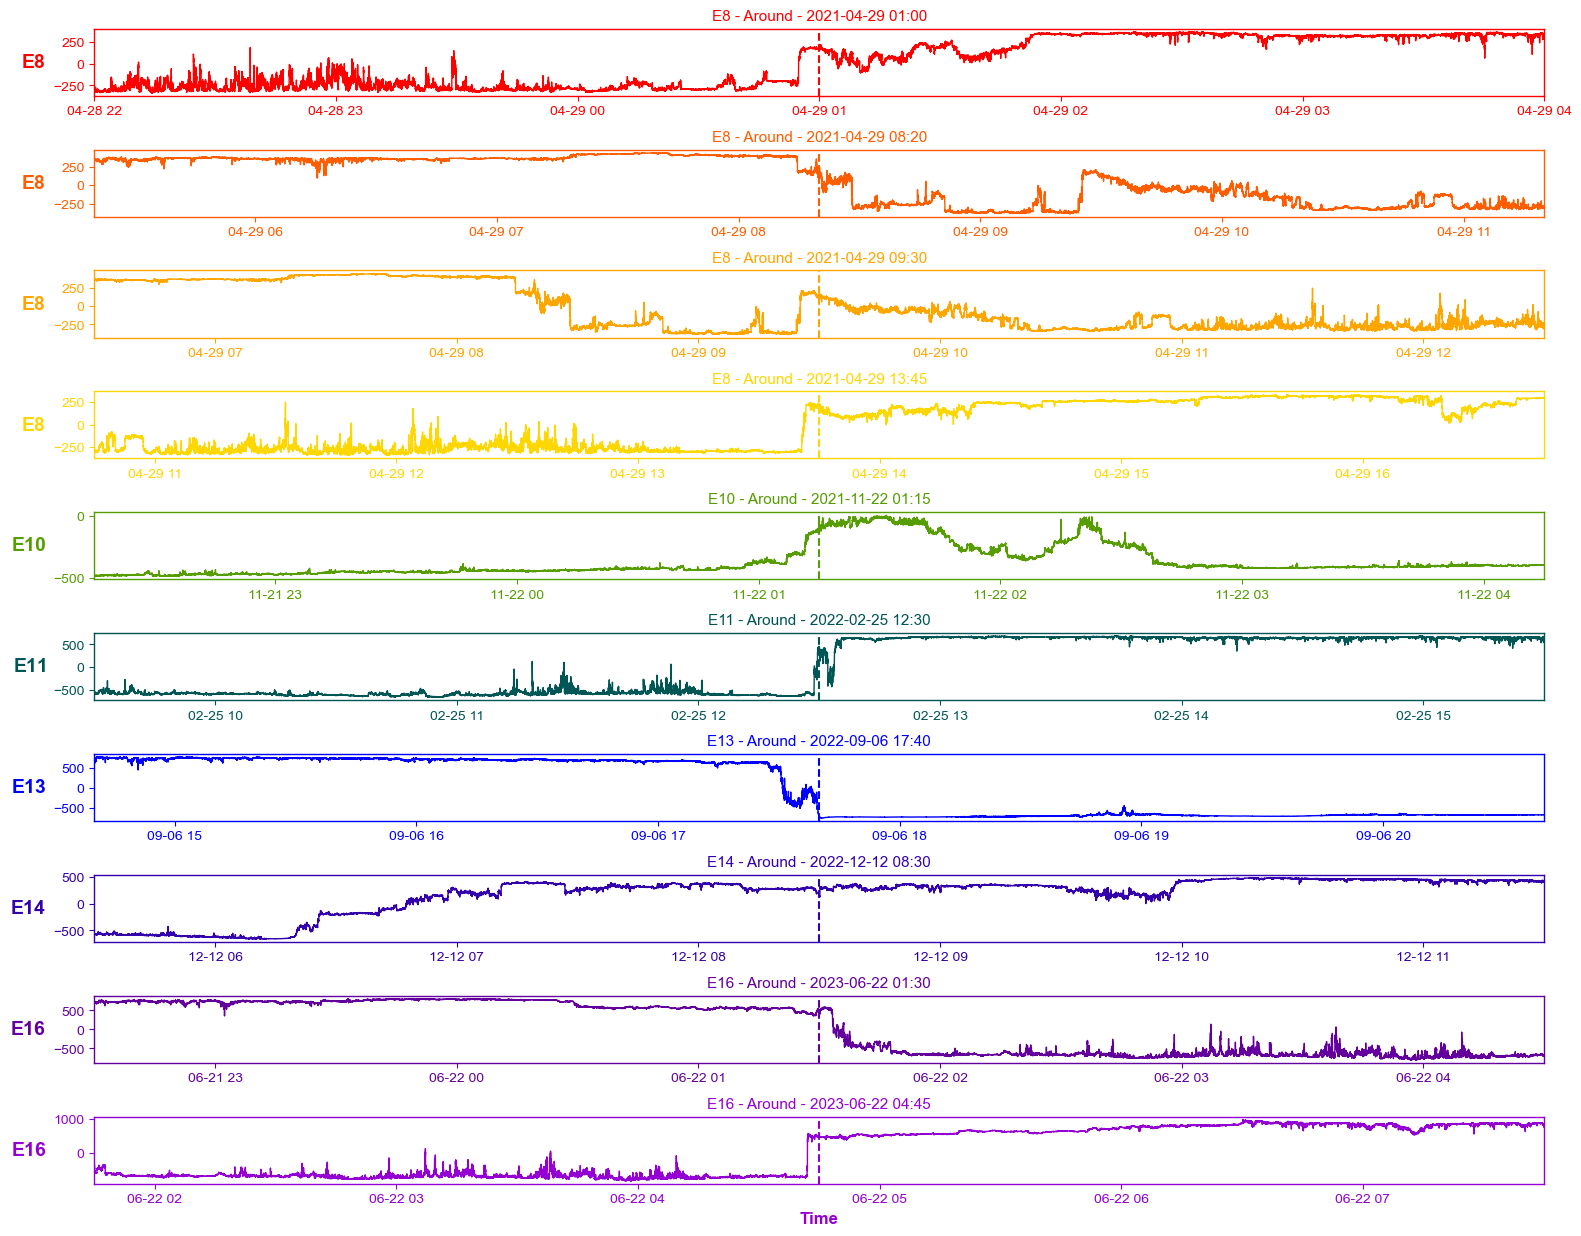

In [36]:
# And we can still create our plots this way! 🙌

# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# Update plt.options with the multiplot settings
plt.options.window = '06:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = False
plt.options.single_title_text = "Br Around PSP HCS Crossings"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = False
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

# Call multiplot with updated options
multiplot([
    ('2021-04-29/01:00:00.000', mag_rtn_4sa.br),
    ('2021-04-29/08:20:00.000', mag_rtn_4sa.br),
    ('2021-04-29/09:30:00.000', mag_rtn_4sa.br),
    ('2021-04-29/13:45:00.000', mag_rtn_4sa.br),
    ('2021-11-22/01:15:00.000', mag_rtn_4sa.br),
    ('2022-02-25/12:30:00.000', mag_rtn_4sa.br),
    ('2022-09-06/17:40:00.000', mag_rtn_4sa.br),
    ('2022-12-12/08:30:00.000', mag_rtn_4sa.br),
    ('2023-06-22/01:30:00.000', mag_rtn_4sa.br),
    ('2023-06-22/04:45:00.000', mag_rtn_4sa.br)
]);

In [37]:
# STOP 😎 #Who's callin this guy invalid!?
# #This just makes the Run All command stop...

### Audification

In [38]:
# To force selection of a new directory:
SET_NEW_SAVE_DIRECTORY = False  # Set to True to choose a new save directory
audifier.select_save_dir(force_new=SET_NEW_SAVE_DIRECTORY)
print()

Using previously set save directory: /Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23


Button(button_style='info', description='Open Save Directory', style=ButtonStyle(), tooltip='Click to open the…

In [39]:
# Optionally change markers per hour from default 120
audifier.markers_per_hour = 60  # 1 marker every 10 seconds = 360 markers per hour,
audifier.markers_only = False  # Default setting
audifier.quantize_markers = True  # hourly
audifier.sample_rate = 22000
audifier.channels = 1

# trange = ['2024-09-27/05:15.000', '2024-10-03/05:15.000']  # Enc 21

# trange = ['2025-03-23/17:30:00.000', '2025-03-23/18:30:00.000']  # Enc 23 Flapping Proof?
trange = ['2025-03-23/17:56:00.000', '2025-03-23/18:06:00.000']  # Enc 23 Flapping Proof Zoom


print(trange)

# Create audio files and markers from any components
# audifier.audify(trange, mag_rtn_4sa.br, mag_rtn_4sa.bt, mag_rtn_4sa.bn, mag_rtn_4sa.bmag)
audifier.audify(trange, mag_rtn.br, mag_rtn.bt, mag_rtn.bn, mag_rtn.bmag)


['2025-03-23/17:56:00.000', '2025-03-23/18:06:00.000']
Starting audification process...
📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032312_v00.cdf, psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032318_v00.cdf
✅ - CDF Data import complete for mag_RTN range ['2025-03-23/17:56:00.000', '2025-03-23/18:06:00.000'].

📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032312_v00.cdf, psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032318_v00.cdf
📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032312_v00.cdf, psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032318_v00.cdf
📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032312_v00.cdf, psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032318_v00.cdf

DEBUG CLIPPING:
Clipping data to range: 2025-03-23/17:56:00

Button(description='Show Directory', style=ButtonStyle())

Button(description='Open markers', style=ButtonStyle())

Button(description='Open br', style=ButtonStyle())

Button(description='Open bt', style=ButtonStyle())

Button(description='Open bn', style=ButtonStyle())

Button(description='Open bmag', style=ButtonStyle())

{'markers': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_FIELDS_MARKER_SET_2025-03-23_1756_to_1806_60_per_hour.txt',
 'br': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_MAG_RTN_2025-03-23_1756_to_1806_22000SR_Br.wav',
 'bt': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_MAG_RTN_2025-03-23_1756_to_1806_22000SR_Bt.wav',
 'bn': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_MAG_RTN_2025-03-23_1756_to_1806_22000SR_Bn.wav',
 'bmag': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_MAG_RTN_2025-03-23_1756_to_1806_22000SR_Bmag.wav'}

In [40]:
# Optionally change markers per hour from default 120
audifier.markers_per_hour = 60  # 1 marker every 10 seconds = 360 markers per hour,
audifier.markers_only = False  # Default setting
audifier.quantize_markers = True  # hourly
audifier.sample_rate = 15000
audifier.fade_samples = 2000
audifier.channels = 2

# trange = ['2024-09-27/05:15.000', '2024-10-03/05:15.000']  # Enc 21

# trange = ['2025-03-23/17:30:00.000', '2025-03-23/18:30:00.000']  # Enc 23 Flapping Proof?
trange = ['2025-03-23/17:56:00.000', '2025-03-23/18:06:00.000']  # Enc 23 Flapping Proof Zoom


print(trange)

# Create audio files and markers from any components
# audifier.audify(trange, mag_rtn_4sa.br, mag_rtn_4sa.bt, mag_rtn_4sa.bn, mag_rtn_4sa.bmag)
audifier.audify(trange, mag_rtn.bt, mag_rtn.bn)


['2025-03-23/17:56:00.000', '2025-03-23/18:06:00.000']
Starting audification process...
📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032312_v00.cdf, psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032318_v00.cdf
📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032312_v00.cdf, psp_data/fields/l2/mag_rtn/2025/psp_fld_l2_mag_RTN_2025032318_v00.cdf

DEBUG CLIPPING:
Clipping data to range: 2025-03-23/17:56:00.000 to 2025-03-23/18:06:00.000
Original data points: 175780
Points in range: 175780

Save directory already ends with encounter 'E23'. Using: /Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23
Output directory: /Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806
Generating markers for time range: 2025-03-23/17:56:00.000 to 2025-03-23/18:06:00.000
Number of

Button(description='Show Directory', style=ButtonStyle())

Button(description='Open markers', style=ButtonStyle())

Button(description='Open stereo_Bt_Bn', style=ButtonStyle())

{'markers': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_FIELDS_MARKER_SET_2025-03-23_1756_to_1806_60_per_hour.txt',
 'stereo_Bt_Bn': '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__HCS_Crossing_Catalogue/HCS_Crossings/E23/E23_2025_03_23_1756_to_1806/E23_PSP_MAG_RTN_2025-03-23_1756_to_1806_15000SR_Bt_L_Bn_R.wav'}

=== Magnetic Field Data Analysis ===

1. Data Structure Checks:
Data type: <class 'plotbot.plot_manager.plot_manager'>
Shape: (98876,)
Number of points: 98876
Memory usage: 0.40 MB

2. Basic Statistics:
Mean |B|: 757.44 nT
Median |B|: 733.61 nT
Standard deviation: 87.92 nT
Min |B|: 318.48 nT
Max |B|: 1006.42 nT

3. Component Analysis:
Mean values:
⟨Br⟩: 44.66 nT
⟨Bt⟩: -117.22 nT
⟨Bn⟩: 44.11 nT

4. Field Orientation:
Mean θ (from radial): 89.84°
Mean φ (azimuthal): 54.56°

5. Energy Analysis:
Mean B²: 581450.12 nT²
Mean magnetic energy density: 2.31e+02 J/m³

6. Time Series Properties:
Mean sampling cadence: 0.218454 seconds
Dominant frequency in power spectrum: 1.79e-02 Hz

7. Data Quality Metrics:
Number of NaN values: 16
Number of zeros: 0
Number of values > 3σ: 570



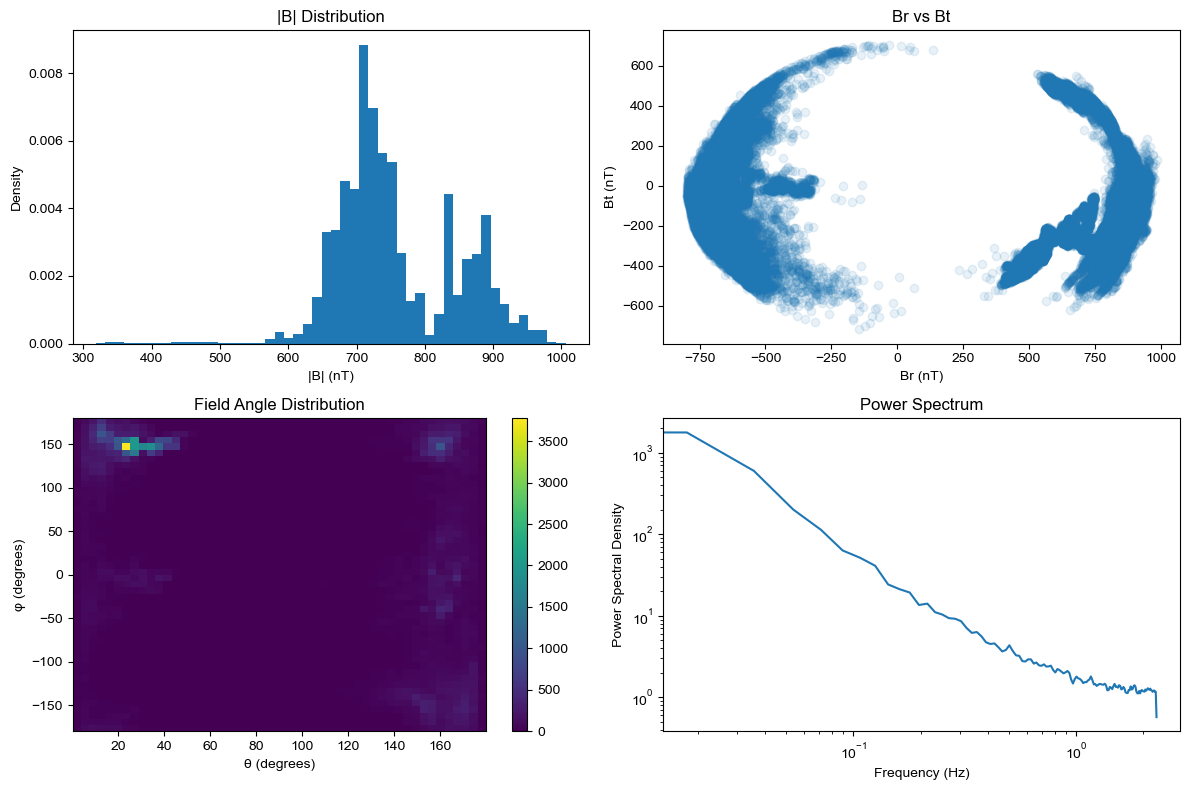

In [41]:
#Working with Plotbot.data!! (the format is actually "mag_rtn_4sa.bmag.data " but you know what I mean...)

# Statistical Analysis of Magnetic Field Data
print("=== Magnetic Field Data Analysis ===\n")

# Convert plot_manager objects to numpy arrays for analysis
bmag_data = mag_rtn_4sa.bmag.data  
br_data = mag_rtn_4sa.br.data
bt_data = mag_rtn_4sa.bt.data
bn_data = mag_rtn_4sa.bn.data

# Basic checks
print("1. Data Structure Checks:")
print(f"Data type: {type(mag_rtn_4sa.bmag)}")
print(f"Shape: {np.shape(bmag_data)}")
print(f"Number of points: {len(bmag_data)}")
print(f"Memory usage: {bmag_data.nbytes / 1e6:.2f} MB\n")

# Basic statistics
print("2. Basic Statistics:")
print(f"Mean |B|: {np.nanmean(bmag_data):.2f} nT")
print(f"Median |B|: {np.nanmedian(bmag_data):.2f} nT")
print(f"Standard deviation: {np.nanstd(bmag_data):.2f} nT")
print(f"Min |B|: {np.nanmin(bmag_data):.2f} nT")
print(f"Max |B|: {np.nanmax(bmag_data):.2f} nT\n")

# Component analysis
print("3. Component Analysis:")
print("Mean values:")
print(f"⟨Br⟩: {np.nanmean(br_data):.2f} nT")
print(f"⟨Bt⟩: {np.nanmean(bt_data):.2f} nT")
print(f"⟨Bn⟩: {np.nanmean(bn_data):.2f} nT\n")

# Calculate field angles
theta = np.arctan2(np.sqrt(bt_data**2 + bn_data**2), br_data)
phi = np.arctan2(bn_data, bt_data)

print("4. Field Orientation:")
print(f"Mean θ (from radial): {np.degrees(np.nanmean(theta)):.2f}°")
print(f"Mean φ (azimuthal): {np.degrees(np.nanmean(phi)):.2f}°\n")

# Power and energy density
mu0 = 4 * np.pi * 1e-7  # permeability of free space
B_squared = bmag_data**2
energy_density = B_squared / (2 * mu0) * 1e-9  # Convert to J/m^3

print("5. Energy Analysis:")
print(f"Mean B²: {np.nanmean(B_squared):.2f} nT²")
print(f"Mean magnetic energy density: {np.nanmean(energy_density):.2e} J/m³\n")

# Time series analysis
if hasattr(mag_rtn_4sa, 'datetime_array'):
    print("6. Time Series Properties:")
    # Convert datetime array to numeric values for time difference calculation
    time_array = np.array(mag_rtn_4sa.datetime_array, dtype='datetime64[ns]')
    time_diffs = np.diff(time_array)
    mean_cadence_ns = np.mean(time_diffs)
    mean_cadence_s = mean_cadence_ns / np.timedelta64(1, 's')  # Convert to seconds
    print(f"Mean sampling cadence: {mean_cadence_s:.6f} seconds")
    
    # Calculate power spectrum using sampling frequency in Hz
    from scipy import signal
    fs = 1.0 / mean_cadence_s
    # Remove NaN values for spectrum calculation
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        f, Pxx = signal.welch(valid_data - np.mean(valid_data), fs=fs)
        peak_freq = f[np.argmax(Pxx)]
        print(f"Dominant frequency in power spectrum: {peak_freq:.2e} Hz\n")

# Data quality checks
print("7. Data Quality Metrics:")
print(f"Number of NaN values: {np.sum(np.isnan(bmag_data))}")
print(f"Number of zeros: {np.sum(bmag_data == 0)}")
print(f"Number of values > 3σ: {np.sum(np.abs(bmag_data - np.nanmean(bmag_data)) > 3*np.nanstd(bmag_data))}\n")

# Visualization
plt.figure(figsize=(12, 8))

# Plot 1: Histogram of |B|
plt.subplot(221)
plt.hist(bmag_data[~np.isnan(bmag_data)], bins=50, density=True)
plt.title('|B| Distribution')
plt.xlabel('|B| (nT)')
plt.ylabel('Density')

# Plot 2: Component correlations
plt.subplot(222)
mask = ~np.isnan(br_data) & ~np.isnan(bt_data)
plt.scatter(br_data[mask], bt_data[mask], alpha=0.1)
plt.xlabel('Br (nT)')
plt.ylabel('Bt (nT)')
plt.title('Br vs Bt')

# Plot 3: Field angle distribution
plt.subplot(223)
mask = ~np.isnan(theta) & ~np.isnan(phi)
plt.hist2d(np.degrees(theta[mask]), np.degrees(phi[mask]), bins=50)
plt.xlabel('θ (degrees)')
plt.ylabel('φ (degrees)')
plt.title('Field Angle Distribution')
plt.colorbar()

# Plot 4: Power spectrum
plt.subplot(224)
if hasattr(mag_rtn_4sa, 'datetime_array'):
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        plt.loglog(f, Pxx)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('Power Spectrum')

plt.tight_layout()
plt.show()